<a href="https://colab.research.google.com/github/alexrafkin/predicting_sentencing_length/blob/main/InmateAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

While our society today seems to be facing an innumerable amount of systemic issues, few feel as pressing as mass incarceration. Much of the data and information regarding mass incarceration has been obscured until recently. By understanding the history of incarceration, the justice system, and the data behind it, we can take steps towards demystifying and unveiling the reality behind our massive prison system. Whether you work in the legal system, are at all interested in social justice, or want to garner a better understanding of what is and has historically been going on in our country, this project might interest you.

In this project, I am working with a dataset from the Illinois Department of Corrections. This dataset contains information on the parole population of Illinois as of September 30, 2020. It catalogues around 24,000 people who have been released on parole. For each person, the dataset has their ID Number, Name, DoB, Sex, Race, Veteran Status, Current Admission Date, Admission Type, Parent Institution, Mandatory Supervised Release Date, Projected Discharge Date, Custody Date, Sentence Date, Crime Class, Holding Offense, Sentence Years, Sentence Months, Truth in Sentencing, Sentencing County, County of Residence, and Residence Zip Code.

Given certain characteristics and information about each person, I plan to build a model which can predict the length of time which somebody would be sentenced. I then want to compare it to a reduced model with no personal data about each person, to see if the algorithms are more accurate when using personal data. If there is a significant difference between the two models, then personal data would be a major factor in determining sentence length. I will discuss what is classified as 'personal data' later.

#Acknowledging Potential Bias

This dataset is a collection of people who have been released on parole. This means that it does not include people who are still currently incarcerated. This means that those who were given longer sentences in this dataset are from earlier, and wouldn't include many people who were recently given long sentences.

Another thing to consider is that many of these people were arrested or sentenced in Chicago, a large city with a history of racist policing. The types of crimes people have been sentenced for in Chicago might, on average, be different than those for which people have been been sentenced in more suburban or rural areas.

#Defining Model Success

When looking at all these different types of models, I want to have some system to evaluate their success and accuracy in predicting sentence length. After building and testing all these models, I will be comparing their R^2, Adjusted R^2, MAE, MSE, RMSE, and MAPE values.

While R^2 and Adjusted R^2 focus on each models' accuracy and a higher number is preferred, the other values focus on each models' inaccuracy. We want to minimize MAE, MSE, RMSE and MAPE.



*   MAE - Mean Absolute Error - Average absolute error in sentence length per person (measured in years).

*   MSE - Mean Squared Error - Average squared error in sentence length per person (measured in years).

*   RMSE - Root Mean Squared Error - Square root of the average squared error (measured in years).

*   MAPE - Mean Absolute Percent Error - Average absolute percent difference between the predicted value and real value of sentence length.



#Imports and Data Preparation

In [ ]:
import math
import random
import statistics
import pandas as pd
import numpy as np
from scipy import stats
import scipy
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()
import warnings
warnings.filterwarnings("ignore")
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

In [ ]:
url = 'https://drive.google.com/file/d/15w4-sSFz9PHmeVvZZJIQz3MOUTFqjKQM/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23931 entries, 0 to 23930
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   IDOC #                                   23931 non-null  object 
 1   Name                                     23931 non-null  object 
 2   Date of Birth                            23931 non-null  object 
 3   Sex                                      23931 non-null  object 
 4   Race                                     23931 non-null  object 
 5   Veteran Status                           23931 non-null  object 
 6   Current Admission Date                   23931 non-null  object 
 7   Admission Type                           23931 non-null  object 
 8   Parent Institution                       23931 non-null  object 
 9   Mandatory Supervised Release (MSR) Date  23931 non-null  object 
 10  Projected Discharge Date3                23089

After importing all the packages we need along with the dataset, we can see we have around 24,000 people to work with. However we do have missing values in 'Projected Discharge Date' and 'Sentence Months'. Something else to notice is that almost all of these features are 'object' datatypes rather than numerical - we will have to change that.

In [ ]:
df['Sentence Years'].sort_values(ascending=False).head(40)

14244     SDP
835       SDP
839       SDP
14453     SDP
153       SDP
4120      SDP
3829      SDP
3400      SDP
10028     SDP
4535      SDP
4496      SDP
9512      SDP
166       SDP
12157     SDP
1952      SDP
371       SDP
3107      SDP
9744      SDP
155      LIFE
64       LIFE
659      LIFE
42       LIFE
87       LIFE
134      LIFE
2751     LIFE
9510     LIFE
4268     LIFE
99       LIFE
104      LIFE
41       LIFE
9461     LIFE
9408     LIFE
32       LIFE
6        LIFE
939      LIFE
7433        9
10313       9
11059       9
22150       9
18121       9
Name: Sentence Years, dtype: object

We want to take out the 'LIFE' and 'SDP' sentences since they will skew the 
data - they do not contain full information about the sentence, and there are less than 20 cases of each.

In [ ]:
def fixSL(dummydf):
  SDP_LIFEs = []
  for i in dummydf.index:
    if dummydf.loc[i,'Sentence Years'] == 'LIFE' or dummydf.loc[i,'Sentence Years'] == 'SDP':
      SDP_LIFEs.append(i)
    else:
      dummydf.loc[i,'Sentence Length'] = int(dummydf.loc[i,'Sentence Years']) + int(dummydf.loc[i,'Sentence Months'])/12
  
  return SDP_LIFEs

We need to fix the sentence length as they are represented by integers rather than strings. We want to adjust TIS to be a float rather than a string, just in case we want to work with it later.

In [ ]:
def fixTIS(dummydf):
  for i in dummydf.index:
    if dummydf.loc[i,'Truth in Sentencing'] == 'Day-for-Day':
      dummydf.loc[i,'TIS'] = 0.5
    elif dummydf.loc[i,'Truth in Sentencing'][0] == '8':
      dummydf.loc[i,'TIS'] = 0.85
    elif dummydf.loc[i,'Truth in Sentencing'] == '100%':
      dummydf.loc[i,'TIS'] = 0.85
    elif dummydf.loc[i,'Truth in Sentencing'][0] == '7':
      dummydf.loc[i,'TIS'] = 0.75

In [ ]:
def localSentence(dummydf):
  for i in dummydf.index:
    if dummydf.loc[i,'County of Residence'] == dummydf.loc[i,'Sentencing County']:
      dummydf.loc[i,'Local Sentence'] = 1
    else:
      dummydf.loc[i,'Local Sentence'] = 0

This will be a dummy variable for whether or not the person was sentenced where they are residents (to determine if there is a local bias).

In [ ]:
def fixDate(date):
  datesplit=date.split('-')

  if datesplit[1] == 'Jan':
    newdate = '1/{}'.format(datesplit[2])
  elif datesplit[1] == 'Feb':
    newdate = '2/{}'.format(datesplit[2])
  elif datesplit[1] == 'Mar':
    newdate = '3/{}'.format(datesplit[2])
  elif datesplit[1] == 'Apr':
    newdate = '4/{}'.format(datesplit[2])
  elif datesplit[1] == 'May':
    newdate = '5/{}'.format(datesplit[2])
  elif datesplit[1] == 'Jun':
    newdate = '6/{}'.format(datesplit[2])
  elif datesplit[1] == 'Jul':
    newdate = '7/{}'.format(datesplit[2])
  elif datesplit[1] == 'Aug':
    newdate = '8/{}'.format(datesplit[2])
  elif datesplit[1] == 'Sep':
    newdate = '9/{}'.format(datesplit[2])
  elif datesplit[1] == 'Oct':
    newdate = '10/{}'.format(datesplit[2])
  elif datesplit[1] == 'Nov':
    newdate = '11/{}'.format(datesplit[2])
  elif datesplit[1] == 'Dec':
    newdate = '12/{}'.format(datesplit[2])

  return newdate

This function just takes the date format from the dataset and changes it to an easier format to work with.

In [ ]:
def getDif(d1, d2, x):
  date1 = fixDate(d1)
  date2 = fixDate(d2)
  if x == 'Months':
    return abs(int(date1.split('/')[0]) - int(date2.split('/')[0]) + 12 * (int(date1.split('/')[1]) - int(date2.split('/')[1])))
  elif x == 'Years':
    return abs((int(date1.split('/')[0]) - int(date2.split('/')[0]))/12 + (int(date1.split('/')[1]) - int(date2.split('/')[1])))

This function gets the difference between two dates in months or years.

In [ ]:
def getATDummies(dummydf):
  for i in dummydf.index:
    if dummydf.loc[i,'Admission Type'] == 'Direct from court':
      dummydf.loc[i,'AT: First Offense'] = 1
    else:
      dummydf.loc[i,'AT: First Offense'] = 0

    if dummydf.loc[i,'Admission Type'] == 'Discharged & recommitted':
      dummydf.loc[i,'AT: Discharged & Recommitted'] = 1
    else:
      dummydf.loc[i,'AT: Discharged & Recommitted'] = 0

    if dummydf.loc[i,'Admission Type'] == 'MSR violator, New sentence' or dummydf.loc[i,'Admission Type'] == 'Parole violator, New sentence' or dummydf.loc[i,'Admission Type'] == 'Technical MSR violator' or dummydf.loc[i,'Admission Type'] == 'Technical parole violator':
      dummydf.loc[i,'AT: Parole Violation'] = 1
    else:
      dummydf.loc[i,'AT: Parole Violation'] = 0

This is creating 'Admission Type' dummy variables - splitting the data into groups of 'First Offense', 'Discharged & Recommitted', 'Parole Violation', or other. These might be useful information in determining sentence length.

In [ ]:
def getClassDummies(dummydf):
  for i in dummydf.index:
    if dummydf.loc[i,'Crime Class'][-1] == '1':
      dummydf.loc[i,'Class 1 Felony'] = 1
    else:
      dummydf.loc[i,'Class 1 Felony'] = 0

    if dummydf.loc[i,'Crime Class'][-1] == '2':
      dummydf.loc[i,'Class 2 Felony'] = 1
    else:
      dummydf.loc[i,'Class 2 Felony'] = 0

    if dummydf.loc[i,'Crime Class'][-1] == '3':
      dummydf.loc[i,'Class 3 Felony'] = 1
    else:
      dummydf.loc[i,'Class 3 Felony'] = 0

    if dummydf.loc[i,'Crime Class'][-1] == 'X':
      dummydf.loc[i,'Class X Felony'] = 1
    else:
      dummydf.loc[i,'Class X Felony'] = 0

    if dummydf.loc[i,'Crime Class'][-1] == 'r':
      dummydf.loc[i,'Murder Felony'] = 1
    else:
      dummydf.loc[i,'Murder Felony'] = 0

Creating dummies for Crime Class.

In [ ]:
def getRaceDummies(dummydf):
  for i in dummydf.index:
    if dummydf.loc[i,'Race'] == 'Black':
      dummydf.loc[i,'Race: Black'] = 1
    else:
      dummydf.loc[i,'Race: Black'] = 0

    if dummydf.loc[i,'Race'] == 'White':
      dummydf.loc[i,'Race: White'] = 1
    else:
      dummydf.loc[i,'Race: White'] = 0
      
    if dummydf.loc[i,'Race'] == 'Hispanic':
      dummydf.loc[i,'Race: Hispanic'] = 1
    else:
      dummydf.loc[i,'Race: Hispanic'] = 0

This creates dummies for Racial data. Since Black, White, and Hispanic are the most common occurences in the dataset, other races will be in the 'dropped' category.

In [ ]:
new_df = df.copy()

In [ ]:
new_df = new_df.drop(23793, axis=0)
new_df = new_df.drop(8070, axis=0)

In [ ]:
droplist = [14827,21179,21305,6586,21430]

new_df = new_df.drop(droplist, axis=0)

In [ ]:
new_df.loc[2788,'Projected Discharge Date3'] = '2-Jul-2016'

These people either have a null birthday, an unclassified crime, or typing errors.

In [ ]:
fixTIS(new_df)
localSentence(new_df)
getATDummies(new_df)
getClassDummies(new_df)
getRaceDummies(new_df)

In [ ]:
for i in new_df.index:
    new_df.loc[i,'Age at Sentencing'] = getDif(new_df.loc[i,'Sentence Date'],new_df.loc[i,'Date of Birth'], 'Years')
    new_df.loc[i,'Sentence Served'] = getDif(new_df.loc[i,'Custody Date'],new_df.loc[i,'Mandatory Supervised Release (MSR) Date'], 'Years')
    new_df.loc[i, 'Sentence Year'] = int(fixDate(new_df.loc[i,'Sentence Date'])[-4:])

In [ ]:
for i in fixSL(new_df):
    new_df = new_df.drop(i, axis=0)

Creating all our dummy variables, dropping LIFE and SDP's, as well as creating some new features which will be useful for our algorithm.

In [ ]:
new_df['Percent of Sentence Served'] = new_df['Sentence Served']/new_df['Sentence Length']

In [ ]:
droplist = ['Truth in Sentencing','Holding Offense','County of Residence', 'Crime Class', 'Sentence Years', 'Sentence Months', 'Residence Zip Code','Veteran Status','Parent Institution', 'Admission Type']
for i in droplist:
  new_df = new_df.drop(i, axis = 1)

In [ ]:
new_df = pd.get_dummies(new_df, columns=['Sex'], prefix='is', drop_first=True)

Dropping unimportant columns and adding an 'isMale' dummy.

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23889 entries, 0 to 23930
Data columns (total 29 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   IDOC #                                   23889 non-null  object 
 1   Name                                     23889 non-null  object 
 2   Date of Birth                            23889 non-null  object 
 3   Race                                     23889 non-null  object 
 4   Current Admission Date                   23889 non-null  object 
 5   Mandatory Supervised Release (MSR) Date  23889 non-null  object 
 6   Projected Discharge Date3                23070 non-null  object 
 7   Custody Date                             23889 non-null  object 
 8   Sentence Date                            23889 non-null  object 
 9   Sentencing County                        23889 non-null  object 
 10  TIS                                      23889

In [ ]:
extremes = new_df[new_df['Sentence Length']>99]

#Data Exploration

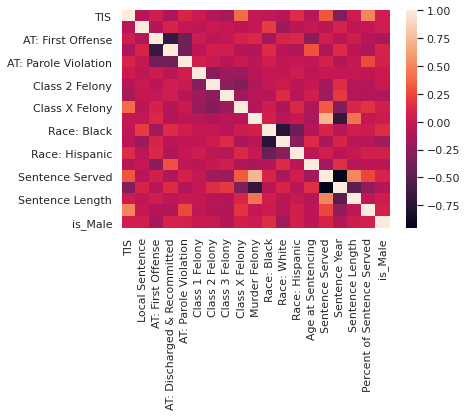

In [ ]:
sns.heatmap(data=new_df.corr())

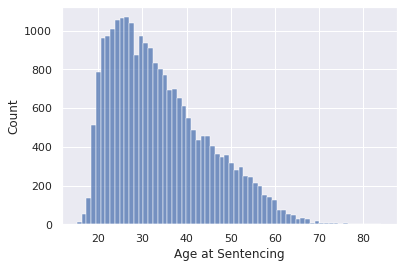

In [ ]:
sns.histplot(data=new_df, x='Age at Sentencing')

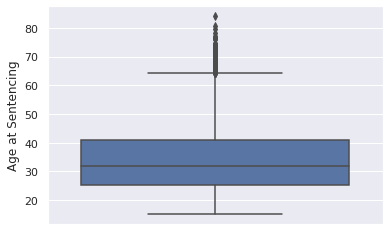

In [ ]:
sns.boxplot(data=new_df, y='Age at Sentencing')

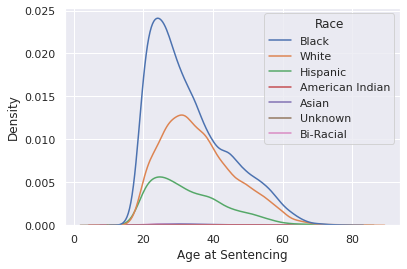

In [ ]:
sns.kdeplot(data=new_df, x='Age at Sentencing', hue = 'Race', common_norm=True)

When looking at age at sentencing, we can see that it looks like black people are arrested earlier in life on average, and also are arrested at a much higher rate, compared to the other races.

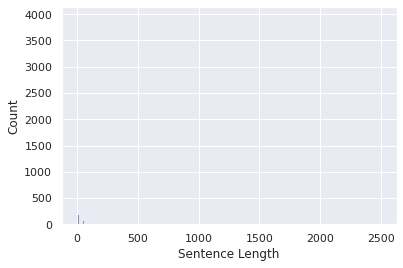

In [ ]:
sns.histplot(data=new_df, x='Sentence Length')

In [ ]:
new_df = new_df.drop(2790, axis=0)
new_df = new_df.drop(2769, axis=0)

We should drop these two extremely high values, as they are outliers skewing the data.

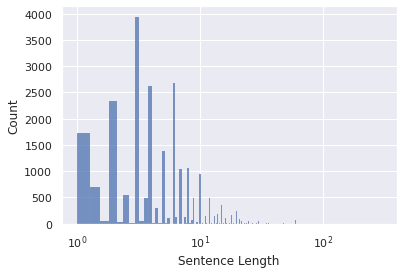

In [ ]:
sns.histplot(data=new_df, x='Sentence Length')
plt.xscale('log')

In [ ]:
new_df['log_sentence'] = np.log(new_df['Sentence Length'])

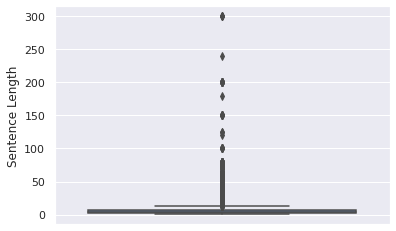

In [ ]:
sns.boxplot(data=new_df, y='Sentence Length')

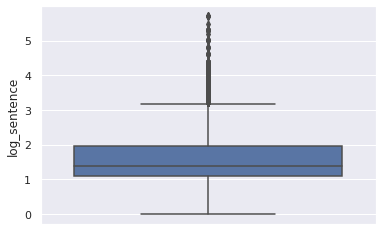

In [ ]:
sns.boxplot(data=new_df, y='log_sentence')

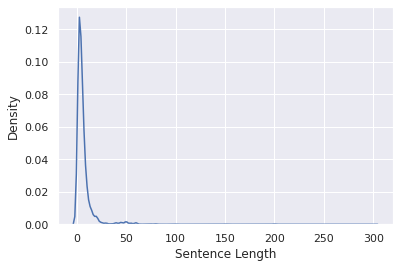

In [ ]:
sns.kdeplot(data=new_df, x='Sentence Length', common_norm=False)

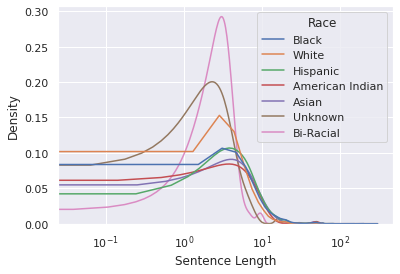

In [ ]:
sns.kdeplot(data=new_df, x='Sentence Length', hue = 'Race', common_norm=False)
plt.xscale('log')

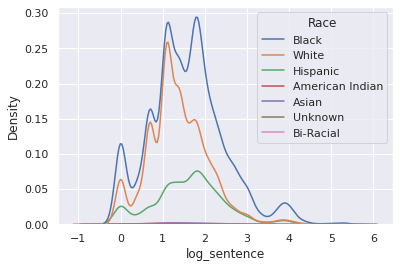

In [ ]:
sns.kdeplot(data=new_df, x='log_sentence', hue = 'Race', common_norm=True)

Now lets look at how much time people actually spent incarcerated.

In [ ]:
new_df.sort_values('Percent of Sentence Served').tail(3)

,IDOC #,Name,Date of Birth,Race,Current Admission Date,Mandatory Supervised Release (MSR) Date,Projected Discharge Date3,Custody Date,Sentence Date,Sentencing County,TIS,Local Sentence,AT: First Offense,AT: Discharged & Recommitted,AT: Parole Violation,Class 1 Felony,Class 2 Felony,Class 3 Felony,Class X Felony,Murder Felony,Race: Black,Race: White,Race: Hispanic,Age at Sentencing,Sentence Served,Sentence Year,Sentence Length,Percent of Sentence Served,is_Male,log_sentence
501,B14448,"PIOTROWSKI, JOHN A.",18-May-1958,White,31-Dec-2007,22-Jan-2019,22-Jan-2016,22-Jan-2002,19-Mar-2008,Cook,0.5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,49.833333,17.000000,2008.0,3.0,5.666667,1,1.098612
9864,N71729,"WHITE, MAX A.",4-Aug-1963,Black,13-Feb-2015,18-Sep-2020,18-Sep-2023,18-Sep-2014,6-Feb-2015,Lake,0.5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,51.500000,6.000000,2015.0,1.0,6.000000,1,0.000000
3786,K76943,"WALKER, XAVIER",18-Oct-1979,Black,1-Oct-1999,12-Dec-2019,12-Dec-2021,21-May-1999,28-Sep-1999,Cook,0.5,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,19.916667,20.583333,1999.0,3.0,6.861111,1,1.098612


In [ ]:
new_df['log_%served'] = np.log(new_df['Percent of Sentence Served'])

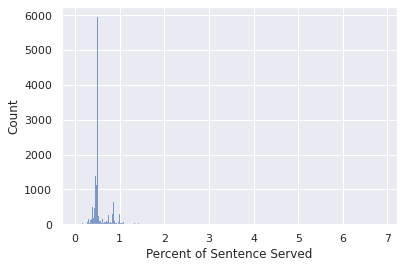

In [ ]:
sns.histplot(data=new_df, x='Percent of Sentence Served')

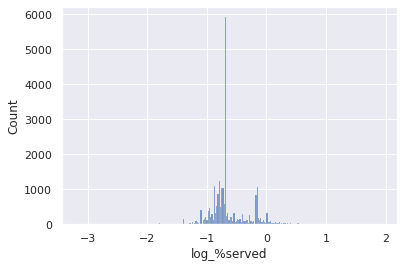

In [ ]:
sns.histplot(data=new_df, x='log_%served')

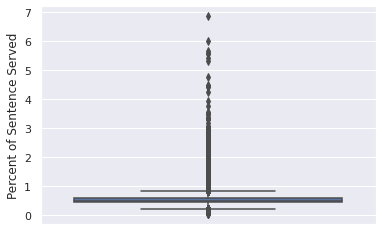

In [ ]:
sns.boxplot(data=new_df, y='Percent of Sentence Served')

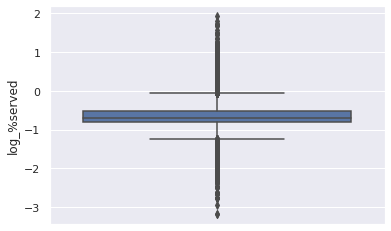

In [ ]:
sns.boxplot(data=new_df, y='log_%served')

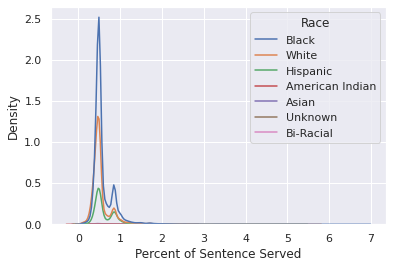

In [ ]:
sns.kdeplot(data=new_df, x='Percent of Sentence Served', hue = 'Race', common_norm=True)

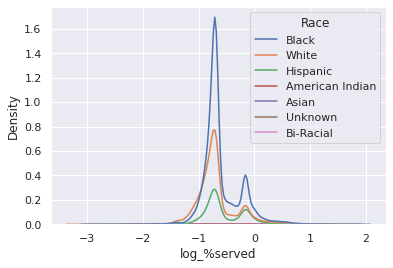

In [ ]:
sns.kdeplot(data=new_df, x='log_%served', hue = 'Race', common_norm=True)

In [ ]:
new_df['Percent of TIS Served'] = new_df['Percent of Sentence Served'] / new_df['TIS']

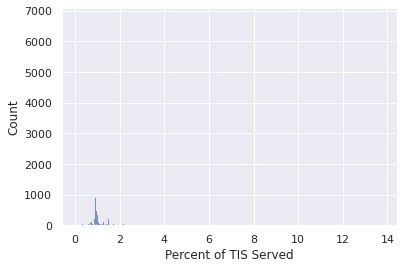

In [ ]:
sns.histplot(data=new_df, x='Percent of TIS Served')

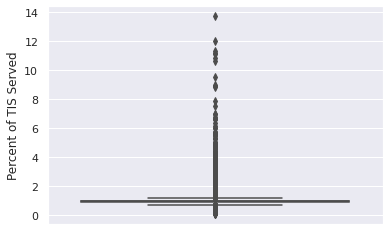

In [ ]:
sns.boxplot(data=new_df, y='Percent of TIS Served')

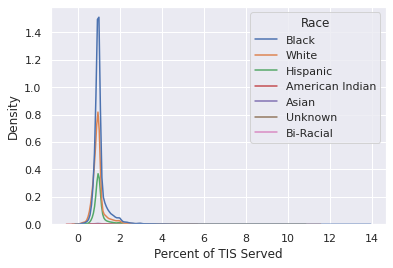

In [ ]:
sns.kdeplot(data=new_df, x='Percent of TIS Served', hue = 'Race', common_norm=True)

In [ ]:
new_df['log_%tis'] = np.log(new_df['Percent of TIS Served'])

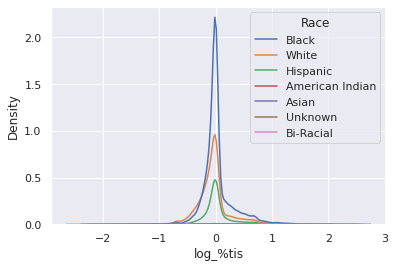

In [ ]:
sns.kdeplot(data=new_df, x='log_%tis', hue = 'Race', common_norm=True)

While that information is interesting to look at, I'm not sure I'll use it in my model.

In [ ]:
new_df.groupby('Race').mean()

,TIS,Local Sentence,AT: First Offense,AT: Discharged & Recommitted,AT: Parole Violation,Class 1 Felony,Class 2 Felony,Class 3 Felony,Class X Felony,Murder Felony,Race: Black,Race: White,Race: Hispanic,Age at Sentencing,Sentence Served,Sentence Year,Sentence Length,Percent of Sentence Served,is_Male,log_sentence,log_%served,Percent of TIS Served,log_%tis
Race,,,,,,,,,,,,,,,,,,,,,,,
American Indian,0.542424,0.484848,0.545455,0.363636,0.090909,0.212121,0.424242,0.060606,0.060606,0.030303,0.0,0.0,0.0,40.959596,2.921717,2017.060606,5.300505,0.573355,0.606061,1.289642,-0.662576,1.062315,-0.033748
Asian,0.559195,0.551724,0.540230,0.241379,0.172414,0.218391,0.287356,0.149425,0.218391,0.022989,0.0,0.0,0.0,34.495211,3.716475,2015.919540,6.396552,0.577389,0.850575,1.499730,-0.637005,1.022512,-0.033907
Bi-Racial,0.518421,0.614035,0.912281,0.035088,0.052632,0.157895,0.421053,0.192982,0.052632,0.000000,0.0,0.0,0.0,28.519006,1.728070,2018.087719,3.301170,0.518329,0.350877,1.084439,-0.703894,0.999937,-0.038675
Black,0.539645,0.750098,0.328290,0.453320,0.196911,0.164145,0.288783,0.116720,0.192522,0.035588,1.0,0.0,0.0,33.257205,4.288659,2015.910245,7.698100,0.587032,0.949988,1.569864,-0.603246,1.084340,0.029709
Hispanic,0.580365,0.607303,0.532671,0.268097,0.177771,0.199552,0.244715,0.072710,0.288917,0.028507,0.0,0.0,1.0,32.888640,4.428732,2015.432095,7.083734,0.625186,0.954196,1.600186,-0.551747,1.068386,0.018993
Unknown,0.507609,0.847826,0.608696,0.065217,0.065217,0.108696,0.326087,0.217391,0.043478,0.000000,0.0,0.0,0.0,32.096014,1.862319,2018.804348,3.184783,0.574036,0.934783,0.927352,-0.616587,1.132822,0.065025
White,0.531329,0.534746,0.462042,0.357996,0.161721,0.157225,0.308028,0.193963,0.115093,0.012075,0.0,1.0,0.0,35.891362,2.967416,2016.783687,5.429319,0.547667,0.844059,1.364171,-0.687526,1.021090,-0.042104


These differences in racial averages are also interesting to look at - although its important to recognize the differences in sample size for each race as well. I trust the averages for black, white, and hispanic more than that of the other races, since they might not have large enough sample sizes to be an accurate representation.

In [ ]:
new_df.groupby('Race').count()

,IDOC #,Name,Date of Birth,Current Admission Date,Mandatory Supervised Release (MSR) Date,Projected Discharge Date3,Custody Date,Sentence Date,Sentencing County,TIS,Local Sentence,AT: First Offense,AT: Discharged & Recommitted,AT: Parole Violation,Class 1 Felony,Class 2 Felony,Class 3 Felony,Class X Felony,Murder Felony,Race: Black,Race: White,Race: Hispanic,Age at Sentencing,Sentence Served,Sentence Year,Sentence Length,Percent of Sentence Served,is_Male,log_sentence,log_%served,Percent of TIS Served,log_%tis
Race,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
American Indian,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33
Asian,87,87,87,87,87,81,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87
Bi-Racial,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57
Black,12757,12757,12757,12757,12757,12562,12757,12757,12757,12757,12757,12757,12757,12757,12757,12757,12757,12757,12757,12757,12757,12757,12757,12757,12757,12757,12757,12757,12757,12757,12757,12757
Hispanic,3122,3122,3122,3122,3122,2787,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122
Unknown,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46
White,7785,7785,7785,7785,7785,7502,7785,7785,7785,7785,7785,7785,7785,7785,7785,7785,7785,7785,7785,7785,7785,7785,7785,7785,7785,7785,7785,7785,7785,7785,7785,7785


In [ ]:
new_df['black_age'] = new_df['Age at Sentencing']*new_df['Race: Black']
new_df['white_age'] = new_df['Age at Sentencing']*new_df['Race: White']
new_df['hispanic_age'] = new_df['Age at Sentencing']*new_df['Race: Hispanic']
new_df['black_FO'] = new_df['AT: First Offense']*new_df['Race: Black']
new_df['white_FO'] = new_df['AT: First Offense']*new_df['Race: White']
new_df['hispanic_FO'] = new_df['AT: First Offense']*new_df['Race: Hispanic']
new_df['black_D&R'] = new_df['AT: Discharged & Recommitted']*new_df['Race: Black']
new_df['white_D&R'] = new_df['AT: Discharged & Recommitted']*new_df['Race: White']
new_df['hispanic_D&R'] = new_df['AT: Discharged & Recommitted']*new_df['Race: Hispanic']
new_df['black_PV'] = new_df['AT: Parole Violation']*new_df['Race: Black']
new_df['white_PV'] = new_df['AT: Parole Violation']*new_df['Race: White']
new_df['hispanic_PV'] = new_df['AT: Parole Violation']*new_df['Race: Hispanic']
new_df['black_C1'] = new_df['Class 1 Felony']*new_df['Race: Black']
new_df['white_C1'] = new_df['Class 1 Felony']*new_df['Race: White']
new_df['hispanic_C1'] = new_df['Class 1 Felony']*new_df['Race: Hispanic']
new_df['black_C2'] = new_df['Class 2 Felony']*new_df['Race: Black']
new_df['white_C2'] = new_df['Class 2 Felony']*new_df['Race: White']
new_df['hispanic_C2'] = new_df['Class 2 Felony']*new_df['Race: Hispanic']
new_df['black_C3'] = new_df['Class 3 Felony']*new_df['Race: Black']
new_df['white_C3'] = new_df['Class 3 Felony']*new_df['Race: White']
new_df['hispanic_C3'] = new_df['Class 3 Felony']*new_df['Race: Hispanic']
new_df['black_CX'] = new_df['Class X Felony']*new_df['Race: Black']
new_df['white_CX'] = new_df['Class X Felony']*new_df['Race: White']
new_df['hispanic_CX'] = new_df['Class X Felony']*new_df['Race: Hispanic']
new_df['black_CM'] = new_df['Murder Felony']*new_df['Race: Black']
new_df['white_CM'] = new_df['Murder Felony']*new_df['Race: White']
new_df['hispanic_CM'] = new_df['Murder Felony']*new_df['Race: Hispanic']
new_df['black_SY'] = new_df['Sentence Year']*new_df['Race: Black']
new_df['white_SY'] = new_df['Sentence Year']*new_df['Race: White']
new_df['hispanic_SY'] = new_df['Sentence Year']*new_df['Race: Hispanic']
new_df['black_LS'] = new_df['Local Sentence']*new_df['Race: Black']
new_df['white_LS'] = new_df['Local Sentence']*new_df['Race: White']
new_df['hispanic_LS'] = new_df['Local Sentence']*new_df['Race: Hispanic']

Here I am adding all the racial interaction terms with Age, Admission Type, and whether they were locally sentenced.

In [ ]:
featurelist = ['is_Male','Age at Sentencing','Sentence Year','Local Sentence','Race: Hispanic','Race: Black','Race: White','Murder Felony','Class X Felony','Class 1 Felony','Class 2 Felony','Class 3 Felony', 'AT: Parole Violation','AT: Discharged & Recommitted','AT: First Offense']
for col in new_df.columns[33:66]:
  featurelist.append(col)

Creating my final feature list for my models.

#Modeling

In [ ]:
performance = pd.DataFrame(columns=['Model','R^2','Adjusted R^2','MAE','MSE','RMSE','MAPE'])

This dataframe will track the performance of a single instance of each model - we will cross validate at the end, but this is just to follow along!

##Linear Regression with OLS


In [ ]:
# `Y` is the target variable
Y = new_df['Sentence Length']
# `X` is the feature set which includes the
X = new_df[featurelist]

# Create a `LinearRegression` model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# Fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 2.61535142e-01 -2.61888351e-02 -5.97656833e-01 -1.64614943e-01
  5.11533982e+02  2.02028877e+03  9.63790903e+02  3.39568662e+01
  5.71473653e+00  2.81521646e+00  1.36884483e+00  9.54565792e-01
 -1.09235342e+00  4.02961263e-01 -6.19283564e-01  3.47571918e-02
  2.89179936e-02  3.56072915e-02  1.54424828e-02  5.55923940e-01
 -6.07579588e-01 -8.16185274e-01  4.07376688e-02 -8.76839976e-01
 -5.44404507e-01  4.56112847e-01 -1.80060560e+00 -1.67380176e+00
 -6.49926924e-01 -4.63902546e-01 -6.48327388e-01 -3.50836845e-01
  3.22034575e-01 -1.32082369e-01 -5.15457742e-02  2.83121384e-01
 -4.95563959e+00 -3.50288898e+00 -2.27534937e+00 -1.87205139e+01
 -3.48996381e+00 -1.22895213e+01 -1.00120000e+00 -4.78139998e-01
 -2.53634715e-01  3.98571325e-01  3.71437587e-01  2.31948894e-01]

Intercept: 
 1209.3803336038914


In [ ]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Sentence Length   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     1393.
Date:                Thu, 21 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:48:23   Log-Likelihood:                -75006.
No. Observations:               23887   AIC:                         1.501e+05
Df Residuals:                   23838   BIC:                         1.505e+05
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         1209.3803    384.142      3.148      0.002     456.437    1962.323
is_Male                          0.2615      0.134      1.954      0.051      -0.001       0.524
Age at Sentencing               -0.0262      0.038     -0.686      0.493      -0.101       0.049
Sentence Year                   -0.5977      0.190     -3.142      0.002      -0.971      -0.225
Local Sentence                  -0.1646      0.824     -0.200      0.842      -1.780       1.450
Race: Hispanic                 511.5340    389.692      1.313      0.189    -252.287    1275.354
Race: Black                   2020.2888    385.486      5.241      0.000    1264.711    2775.867
Race: White                    963.7909    387.505      2.487      0.013     204.257    1723.325
Murder Felony                   33.9569      5.160      6.581      0.000      23.843      44.071
Class X Felony                   5.7147      1.783      3.205      0.001       2.219       9.210
Class 1 Felony                   2.8152      1.347      2.090      0.037       0.175       5.456
Class 2 Felony                   1.3688      1.155      1.185      0.236      -0.896       3.634
Class 3 Felony                   0.9546      1.309      0.729      0.466      -1.611       3.520
AT: Parole Violation            -1.0924      1.925     -0.567      0.570      -4.866       2.681
AT: Discharged & Recommitted     0.4030      1.733      0.233      0.816      -2.993       3.799
AT: First Offense               -0.6193      1.530     -0.405      0.686      -3.618       2.379
black_age                        0.0348      0.039      0.903      0.367      -0.041       0.110
white_age                        0.0289      0.039      0.748      0.455      -0.047       0.105
hispanic_age                     0.0356      0.040      0.901      0.367      -0.042       0.113
black_FO                         0.0154      1.569      0.010      0.992      -3.061       3.092
white_FO                         0.5559      1.603      0.347      0.729      -2.586       3.698
hispanic_FO                     -0.6076      1.684     -0.361      0.718      -3.908       2.693
black_D&R                       -0.8162      1.767     -0.462      0.644      -4.280       2.648
white_D&R                        0.0407      1.799      0.023      0.982      -3.485       3.566
hispanic_D&R                    -0.8768      1.876     -0.467      0.640      -4.554       2.800
black_PV                        -0.5444      1.958     -0.278      0.781      -4.383       3.294
white_PV                         0.4561      1.988      0.229      0.819      -3.441       4.353
hispanic_PV                     -1.8006      2.061     -0.874      0.382      -5.841       2.239
black_C1                        -1.6738      1.358     -1.232      0.218    

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 19109
The number of observations in test set is 4778


In [ ]:
# Create a `LinearRegression` model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# Fit method estimates the coefficients using OLS
lrm.fit(X_train, y_train)

# Inspect the results
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 6.51771830e-10  2.58294994e-01 -3.07037501e-02 -6.04621227e-01
  4.87327254e-03  4.87835983e+02  1.82866645e+03  1.12560777e+03
  3.37901839e+01  6.31437563e+00  3.02364068e+00  1.40069017e+00
  9.54366381e-01 -1.00000519e+00  4.91220879e-01 -6.17113854e-01
  3.56222907e-02  3.10506720e-02  4.03302213e-02  1.52892191e-01
  6.63798942e-01 -2.49218682e-01 -6.30262449e-01  6.93141605e-02
 -6.44030487e-01 -4.02173485e-01  4.32652747e-01 -1.50092169e+00
 -1.69570186e+00 -1.02927127e+00 -7.37429216e-01 -5.57298798e-01
 -4.71554749e-01  3.30438362e-01 -1.35747377e-01 -6.75360900e-02
  3.17756832e-01 -5.09156965e+00 -4.48487553e+00 -2.93669495e+00
 -1.79601350e+01 -3.03993012e+00 -1.26507604e+01 -9.06243243e-01
 -5.58289743e-01 -2.42043870e-01  1.20960726e-01  2.11366551e-01
  5.69448486e-02]

Intercept: 
 1223.3817257993592


In [ ]:
X_train = sm.add_constant(X_train)
# Fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# Print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Sentence Length   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     1190.
Date:                Thu, 21 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:48:24   Log-Likelihood:                -59141.
No. Observations:               19109   AIC:                         1.184e+05
Df Residuals:                   19060   BIC:                         1.188e+05
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

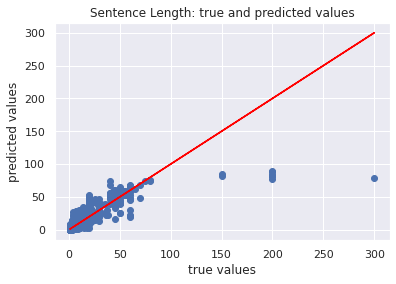

-----Test set statistics-----
R-squared of the model in the test set is: 0.6908804317861506
Mean absolute error of the prediction is: 2.2755762911426776
Mean squared error of the prediction is: 42.67852736618016
Root mean squared error of the prediction is: 6.532880480016465
Mean absolute percentage error of the prediction is: 39.525308469316386


In [ ]:
X_test = sm.add_constant(X_test)

# You are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Sentence Length: true and predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Look at those outliers! Whats going on over there?

In [ ]:
new_df.sort_values('Sentence Length').tail(15)

,IDOC #,Name,Date of Birth,Race,Current Admission Date,Mandatory Supervised Release (MSR) Date,Projected Discharge Date3,Custody Date,Sentence Date,Sentencing County,TIS,Local Sentence,AT: First Offense,AT: Discharged & Recommitted,AT: Parole Violation,Class 1 Felony,Class 2 Felony,Class 3 Felony,Class X Felony,Murder Felony,Race: Black,Race: White,Race: Hispanic,Age at Sentencing,Sentence Served,Sentence Year,Sentence Length,Percent of Sentence Served,is_Male,log_sentence,log_%served,Percent of TIS Served,log_%tis,black_age,white_age,hispanic_age,black_FO,white_FO,hispanic_FO,black_D&R,white_D&R,hispanic_D&R,black_PV,white_PV,hispanic_PV,black_C1,white_C1,hispanic_C1,black_C2,white_C2,hispanic_C2,black_C3,white_C3,hispanic_C3,black_CX,white_CX,hispanic_CX,black_CM,white_CM,hispanic_CM,black_SY,white_SY,hispanic_SY,black_LS,white_LS,hispanic_LS
2777,C68879,"TAYLOR, JAMES",6-Feb-1950,Black,18-Oct-1976,28-Aug-2020,28-Aug-2023,18-Mar-1976,15-Oct-1976,Effingham,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,26.666667,44.416667,1976.0,200.0,0.222083,1,5.298317,-1.504703,0.444167,-0.811555,26.666667,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1976.0,0.0,0.0,0.0,0.0,0.0
4537,L10298,"JOHNSON, DWIGHT",2-Nov-1953,Black,23-Jan-1981,13-Mar-2020,2-Oct-2081,27-Oct-1978,6-Jan-1981,Cook,0.5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,27.166667,41.416667,1981.0,200.0,0.207083,1,5.298317,-1.574634,0.414167,-0.881487,27.166667,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1981.0,0.0,0.0,1.0,0.0,0.0
2768,C61229,"SMITH, ISAAC",11-Dec-1948,Black,8-Apr-1976,2-Aug-2019,12-Oct-2118,8-Dec-1971,7-Apr-1976,Cook,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,27.333333,47.666667,1976.0,200.0,0.238333,1,5.298317,-1.434085,0.476667,-0.740938,27.333333,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1976.0,0.0,0.0,0.0,0.0,0.0
2766,C56160,"TILLER, JOHN L.",10-May-1943,Black,5-Dec-1975,11-Mar-2016,15-Jun-2068,25-May-1975,25-Nov-1975,St. Clair,0.5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,32.500000,40.833333,1975.0,200.0,0.204167,1,5.298317,-1.588819,0.408333,-0.895671,32.500000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1975.0,0.0,0.0,1.0,0.0,0.0
2762,C10666,"CLARK, MICHAEL",29-Nov-1951,Black,11-Oct-1974,3-Jul-2019,24-Jan-2066,12-Oct-1972,4-Oct-1974,Cook,0.5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,22.916667,46.750000,1974.0,200.0,0.233750,1,5.298317,-1.453503,0.467500,-0.760356,22.916667,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1974.0,0.0,0.0,1.0,0.0,0.0
2761,C10609,"HENDERSON, MICHAEL",16-Mar-1953,Black,21-Aug-1974,14-Dec-2018,30-Aug-2068,14-Mar-1973,19-Aug-1974,St. Clair,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,21.416667,45.750000,1974.0,200.0,0.228750,1,5.298317,-1.475126,0.457500,-0.781978,21.416667,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1974.0,0.0,0.0,0.0,0.0,0.0
2759,C01818,"HOWARD, ANDREW",27-May-1945,Black,11-Jan-1974,18-Dec-1992,11-Jan-2072,17-Mar-1973,10-Dec-1973,Cook,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,28.583333,19.750000,1973.0,200.0,0.098750,1,5.298317,-2.315164,0.197500,-1.622017,28.583333,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1973.0,0.0,0.0,0.0,0.0,0.0
2757,C01657,"DEE, HENRY",24-Aug-1946,Black,24-Jul-1972,12-Apr-2019,21-Oct-2168,17-Aug-1971,13-Jul-1972,Cook,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,25.916667,47.666667,1972.0,200.0,0.238333,1,5.298317,-1.434085,0.476667,-0.740938,25.916667,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1972.0,0.0,0.0,0.0,0.0,0.0
2754

Even after taking out a few of the super long sentences, I have to trim off more super long sentences which are skewing the data. Almost all of the super-long sentences, which I am defining as those which are 100 years or longer, are black murder from the 70s. This is an interesting fact in itself, but for now we will trim these off.



In [ ]:
final_df = new_df.copy()

In [ ]:
final_df = final_df[final_df['Sentence Length']<100]

This will be our final dataset.

In [ ]:
final_df[featurelist].head()

,is_Male,Age at Sentencing,Sentence Year,Local Sentence,Race: Hispanic,Race: Black,Race: White,Murder Felony,Class X Felony,Class 1 Felony,Class 2 Felony,Class 3 Felony,AT: Parole Violation,AT: Discharged & Recommitted,AT: First Offense,black_age,white_age,hispanic_age,black_FO,white_FO,hispanic_FO,black_D&R,white_D&R,hispanic_D&R,black_PV,white_PV,hispanic_PV,black_C1,white_C1,hispanic_C1,black_C2,white_C2,hispanic_C2,black_C3,white_C3,hispanic_C3,black_CX,white_CX,hispanic_CX,black_CM,white_CM,hispanic_CM,black_SY,white_SY,hispanic_SY,black_LS,white_LS,hispanic_LS
0,1,66.000000,2020.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,66.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020.0,0.0,0.0,1.0,0.0,0.0
1,1,41.000000,1991.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,41.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1991.0,0.0,0.0,0.0,0.0,0.0
2,1,62.500000,2013.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,62.500000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,0.0,0.0,0.0,0.0
3,1,70.250000,2019.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,70.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,0.0,0.0,0.0,0.0,0.0
4,1,66.333333,2018.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,66.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,0.0,0.0,1.0,0.0,0.0


This is what our final feature list looks like.

In [ ]:
# `Y` is the target variable
Y = final_df['Sentence Length']
# `X` is the feature set which includes the
X = final_df[featurelist]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 19079
The number of observations in test set is 4770


In [ ]:
print('By limiting the sentences to those under 100 years, we have only lost {} instances.'.format(new_df.shape[0] - final_df.shape[0]))

By limiting the sentences to those under 100 years, we have only lost 38 instances.


In [ ]:
# Create a `LinearRegression` model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# Fit method estimates the coefficients using OLS
lrm.fit(X_train, y_train)

# Inspect the results
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 2.64155847e-01 -2.66820017e-02 -5.80228379e-01 -1.53491368e-01
  4.59665739e+02  9.43427671e+02  4.30239297e+02  3.43917065e+01
  5.89416512e+00  2.97041236e+00  1.27446232e+00  7.70464537e-01
 -1.36042286e+00  4.43114082e-01 -6.66652885e-01  3.27963665e-02
  2.46821508e-02  3.67888759e-02 -2.66081109e-01  5.54624394e-01
  2.14362919e-01 -9.87833849e-01  1.21930483e-01 -1.86092988e-01
  7.52407800e-02  1.04027215e+00 -7.18768568e-01 -4.00148264e-01
 -1.77923205e-01 -3.79486236e-01  3.01188413e-01  1.28082571e-01
  4.83986890e-01  1.54912250e-01  1.30701907e-01  5.34044795e-01
 -2.02750051e+00 -1.92740567e+00 -2.21646937e+00 -1.26579872e+01
 -5.53618694e+00 -1.18049445e+01 -4.67659471e-01 -2.13777269e-01
 -2.28381236e-01  2.67754419e-01  3.09379795e-01  2.52132280e-01]

Intercept: 
 1174.2374949414152


In [ ]:
X_train = sm.add_constant(X_train)
# Fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# Print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Sentence Length   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     2240.
Date:                Thu, 21 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:48:25   Log-Likelihood:                -49189.
No. Observations:               19079   AIC:                         9.848e+04
Df Residuals:                   19030   BIC:                         9.886e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

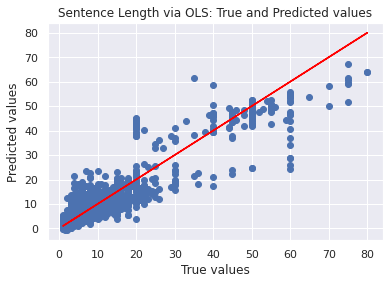

-----Test set statistics-----
R-squared of the model in the test set is: 0.8508536647525037
Mean absolute error of the prediction is: 1.8823814713393767
Mean squared error of the prediction is: 11.345773836860653
Root mean squared error of the prediction is: 3.3683488294505146
Mean absolute percentage error of the prediction is: 34.65113054076912


In [ ]:
X_test = sm.add_constant(X_test)

# You are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Sentence Length via OLS: True and Predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(stats.pearsonr(y_preds,y_test)[0]**2))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

This looks much better than before!

In [ ]:
n=final_df.shape[0]
k=len(featurelist)

In [ ]:
ols_perf = ['OLS',stats.pearsonr(y_preds,y_test)[0]**2,1-((1-stats.pearsonr(y_preds,y_test)[0]**2)*(n-1)/(n-k-1)),mean_absolute_error(y_test, y_preds),mse(y_test, y_preds),rmse(y_test, y_preds),np.mean(np.abs((y_test - y_preds) / y_test)) * 100]

In [ ]:
performance.loc[0] = ols_perf

In [ ]:
performance

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE,MAPE
0,OLS,0.850854,0.850553,1.882381,11.345774,3.368349,34.651131


###Regularization

Lets see if regularization will help our model:

In [ ]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

Best alpha value is: 1e-10
R-squared of the model on the training set is: 0.8478514394751526
-----Test set statistics-----
R-squared of the model on the test set is: 0.8490181005646107
Mean absolute error of the prediction is: 1.8987211826257346
Mean squared error of the prediction is: 11.482290892390393
Root mean squared error of the prediction is: 3.388552920110647
Mean absolute percentage error of the prediction is: 35.14113326088995


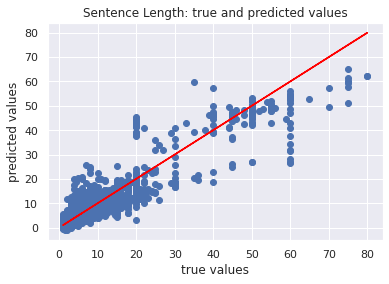

In [ ]:
from sklearn.linear_model import Lasso

lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

# You are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print('Best alpha value is: {}'.format(lasso_cv.alpha_))
print("R-squared of the model on the training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Sentence Length: true and predicted values")
plt.show()

In [ ]:
ols_L_perf = ['OLS_Lasso',lasso_cv.score(X_test, y_test),1-((1-lasso_cv.score(X_test, y_test))*(n-1)/(n-k-1)),mean_absolute_error(y_test, y_preds_test),mse(y_test, y_preds_test),rmse(y_test, y_preds_test),np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100]

In [ ]:
performance.loc[1] = ols_L_perf

Best alpha value is: 1e-05
R-squared of the model on the training set is: 0.8496009536472153
-----Test set statistics-----
R-squared of the model on the test set is: 0.8508113694275959
Mean absolute error of the prediction is: 1.8824339438244297
Mean squared error of the prediction is: 11.345911400477352
Root mean squared error of the prediction is: 3.3683692494258035
Mean absolute percentage error of the prediction is: 34.65439295059106


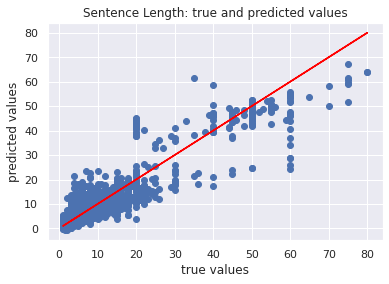

In [ ]:
from sklearn.linear_model import Ridge

ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

# You are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print('Best alpha value is: {}'.format(ridge_cv.alpha_))
print("R-squared of the model on the training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Sentence Length: true and predicted values")
plt.show()

In [ ]:
ols_R_perf = ['OLS_Ridge',ridge_cv.score(X_test, y_test),1-((1-ridge_cv.score(X_test, y_test))*(n-1)/(n-k-1)),mean_absolute_error(y_test, y_preds_test),mse(y_test, y_preds_test),rmse(y_test, y_preds_test),np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100]

In [ ]:
performance.loc[2] = ols_R_perf

Best alpha value is: 1e-10
R-squared of the model on the training set is: 0.8478514394703518
-----Test set statistics-----
R-squared of the model on the test set is: 0.8490181006711217
Mean absolute error of the prediction is: 1.8987211821323882
Mean squared error of the prediction is: 11.48229088429014
Root mean squared error of the prediction is: 3.3885529189154093
Mean absolute percentage error of the prediction is: 35.14113326026412


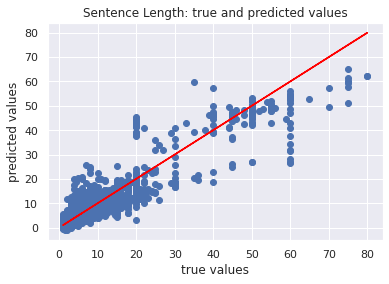

In [ ]:
from sklearn.linear_model import ElasticNet

EN_cv = ElasticNetCV(alphas=alphas, cv=5)
EN_cv.fit(X_train, y_train)

# You are making predictions here
y_preds_train = EN_cv.predict(X_train)
y_preds_test = EN_cv.predict(X_test)

print('Best alpha value is: {}'.format(EN_cv.alpha_))
print("R-squared of the model on the training set is: {}".format(EN_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(EN_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Sentence Length: true and predicted values")
plt.show()

In [ ]:
ols_EN_perf = ['OLS_ElasticNet',EN_cv.score(X_test, y_test),1-((1-EN_cv.score(X_test, y_test))*(n-1)/(n-k-1)),mean_absolute_error(y_test, y_preds_test),mse(y_test, y_preds_test),rmse(y_test, y_preds_test),np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100]

In [ ]:
performance.loc[3] = ols_EN_perf

In [ ]:
performance

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE,MAPE
0,OLS,0.850854,0.850553,1.882381,11.345774,3.368349,34.651131
1,OLS_Lasso,0.849018,0.848714,1.898721,11.482291,3.388553,35.141133
2,OLS_Ridge,0.850811,0.850510,1.882434,11.345911,3.368369,34.654393
3,OLS_ElasticNet,0.849018,0.848714,1.898721,11.482291,3.388553,35.141133


It doesn't seem like regularization made our model any more accurate. Basic OLS seems to fit and predict the best.

##KNN Regression

###Unweighted

In [ ]:
from sklearn import neighbors

# Build the model
knn = neighbors.KNeighborsRegressor(n_neighbors=9)
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                    weights='uniform')

In [ ]:
y_test_preds = knn.predict(X_test)

In [ ]:
r, p_val = stats.pearsonr(y_test, y_test_preds)

R-squared of the model is: 0.8244942556475864
Mean absolute error of the prediction is: 1.9519469679322927
Mean squared error of the prediction is: 13.371395564269136
Root mean squared error of the prediction is: 3.6566918880689325
Mean absolute percentage error of the prediction is: 36.38115977596676


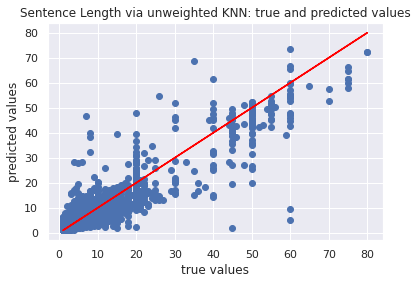

In [ ]:
print("R-squared of the model is: {}".format(r**2))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100))

plt.scatter(y_test, y_test_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Sentence Length via unweighted KNN: true and predicted values")
plt.show()

In [ ]:
KNN_perf = ['KNN',r**2,1-((1-r**2)*(n-1)/(n-k-1)),mean_absolute_error(y_test, y_test_preds),mse(y_test, y_test_preds),rmse(y_test, y_test_preds),np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100]

In [ ]:
performance.loc[4] = KNN_perf

In [ ]:
performance

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE,MAPE
0,OLS,0.850854,0.850553,1.882381,11.345774,3.368349,34.651131
1,OLS_Lasso,0.849018,0.848714,1.898721,11.482291,3.388553,35.141133
2,OLS_Ridge,0.850811,0.850510,1.882434,11.345911,3.368369,34.654393
3,OLS_ElasticNet,0.849018,0.848714,1.898721,11.482291,3.388553,35.141133
4,KNN,0.824494,0.824140,1.951947,13.371396,3.656692,36.381160


###Weighted

In [ ]:
# Run the same model, this time with weights
knn_w = neighbors.KNeighborsRegressor(n_neighbors=9, weights='distance')
knn_w.fit(X_train, y_train)

y_test_preds = knn_w.predict(X_test)
r, p_val = stats.pearsonr(y_test, y_test_preds)

R-squared of the model is: 0.8267474884210565
Mean absolute error of the prediction is: 1.9691870075951385
Mean squared error of the prediction is: 13.192643142930221
Root mean squared error of the prediction is: 3.632167829675581
Mean absolute percentage error of the prediction is: 36.599670694390916


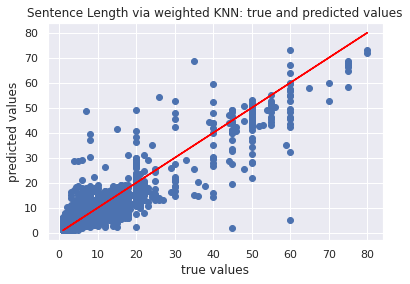

In [ ]:
print("R-squared of the model is: {}".format(r**2))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100))

plt.scatter(y_test, y_test_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Sentence Length via weighted KNN: true and predicted values")
plt.show()

In [ ]:
KNN_w_perf = ['Weighted KNN',r**2,1-((1-r**2)*(n-1)/(n-k-1)),mean_absolute_error(y_test, y_test_preds),mse(y_test, y_test_preds),rmse(y_test, y_test_preds),np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100]

In [ ]:
performance.loc[5] = KNN_w_perf

In [ ]:
performance

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE,MAPE
0,OLS,0.850854,0.850553,1.882381,11.345774,3.368349,34.651131
1,OLS_Lasso,0.849018,0.848714,1.898721,11.482291,3.388553,35.141133
2,OLS_Ridge,0.850811,0.850510,1.882434,11.345911,3.368369,34.654393
3,OLS_ElasticNet,0.849018,0.848714,1.898721,11.482291,3.388553,35.141133
4,KNN,0.824494,0.824140,1.951947,13.371396,3.656692,36.381160
5,Weighted KNN,0.826747,0.826398,1.969187,13.192643,3.632168,36.599671


##Decision Tree

In [ ]:
from sklearn import ensemble
from sklearn import tree

In [ ]:
# Initialize and train the tree
decision_tree = tree.DecisionTreeRegressor(max_depth=7)
decision_tree.fit(X_train, y_train)
y_test_preds = decision_tree.predict(X_test)
r, p_val = stats.pearsonr(y_test, y_test_preds)

R-squared of the model is: 0.8387370552333664
Mean absolute error of the prediction is: 1.8770495402507303
Mean squared error of the prediction is: 12.279478587520458
Root mean squared error of the prediction is: 3.5042086963422223
Mean absolute percentage error of the prediction is: 36.60288159442111


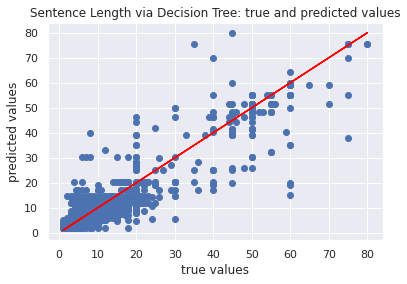

In [ ]:
print("R-squared of the model is: {}".format(r**2))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100))

plt.scatter(y_test, y_test_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Sentence Length via Decision Tree: true and predicted values")
plt.show()

In [ ]:
DT_perf = ['Decision Tree',r**2,1-((1-r**2)*(n-1)/(n-k-1)),mean_absolute_error(y_test, y_test_preds),mse(y_test, y_test_preds),rmse(y_test, y_test_preds),np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100]

In [ ]:
performance.loc[6] = DT_perf

In [ ]:
performance

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE,MAPE
0,OLS,0.850854,0.850553,1.882381,11.345774,3.368349,34.651131
1,OLS_Lasso,0.849018,0.848714,1.898721,11.482291,3.388553,35.141133
2,OLS_Ridge,0.850811,0.850510,1.882434,11.345911,3.368369,34.654393
3,OLS_ElasticNet,0.849018,0.848714,1.898721,11.482291,3.388553,35.141133
4,KNN,0.824494,0.824140,1.951947,13.371396,3.656692,36.381160
5,Weighted KNN,0.826747,0.826398,1.969187,13.192643,3.632168,36.599671
6,Decision Tree,0.838737,0.838412,1.877050,12.279479,3.504209,36.602882


##Random Forest

In [ ]:
rfr = ensemble.RandomForestRegressor()
rfr.fit(X_train,y_train)

y_test_preds = rfr.predict(X_test)
r, p_val = stats.pearsonr(y_test, y_test_preds)

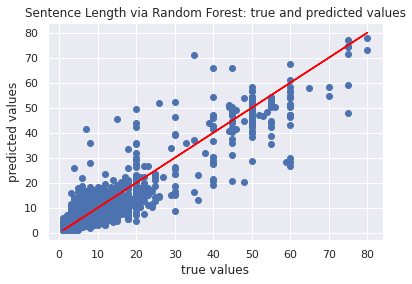

R-squared of the model is: 0.8478738731847234
Mean absolute error of the prediction is: 1.8888162387955625
Mean squared error of the prediction is: 11.600444251431052
Root mean squared error of the prediction is: 3.405942490916582
Mean absolute percentage error of the prediction is: 34.11393220337106


In [ ]:
plt.scatter(y_test, y_test_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Sentence Length via Random Forest: true and predicted values")
plt.show()

print("R-squared of the model is: {}".format(r**2))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100))

In [ ]:
RF_perf = ['Random Forest',r**2,1-((1-r**2)*(n-1)/(n-k-1)),mean_absolute_error(y_test, y_test_preds),mse(y_test, y_test_preds),rmse(y_test, y_test_preds),np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100]

In [ ]:
performance.loc[7] = RF_perf

In [ ]:
performance

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE,MAPE
0,OLS,0.850854,0.850553,1.882381,11.345774,3.368349,34.651131
1,OLS_Lasso,0.849018,0.848714,1.898721,11.482291,3.388553,35.141133
2,OLS_Ridge,0.850811,0.850510,1.882434,11.345911,3.368369,34.654393
3,OLS_ElasticNet,0.849018,0.848714,1.898721,11.482291,3.388553,35.141133
4,KNN,0.824494,0.824140,1.951947,13.371396,3.656692,36.381160
5,Weighted KNN,0.826747,0.826398,1.969187,13.192643,3.632168,36.599671
6,Decision Tree,0.838737,0.838412,1.877050,12.279479,3.504209,36.602882
7,Random Forest,0.847874,0.847567,1.888816,11.600444,3.405942,34.113932


##Support Vector Regression

In [ ]:
from sklearn.svm import SVR
svr = SVR(epsilon=1,C=1000000)
svr.fit(X_train,y_train)

y_test_preds = svr.predict(X_test)
r, p_val = stats.pearsonr(y_test, y_test_preds)

In order to find the best epsilon and C values, I ran a gridsearch algorithm - this took way too long to reproduce so I cut it out in order to have a notebook which would run in a reasonable amount of time.

R-squared of the model is: 0.8521940771459033
Mean absolute error of the prediction is: 1.8753200603320295
Mean squared error of the prediction is: 11.290460368486807
Root mean squared error of the prediction is: 3.3601280285856383
Mean absolute percentage error of the prediction is: 34.72432736205823


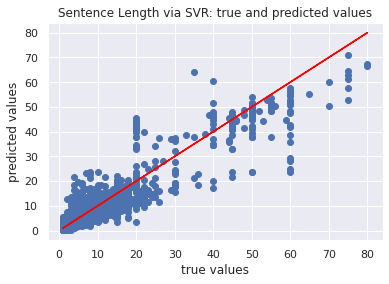

In [ ]:
print("R-squared of the model is: {}".format(r**2))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100))

plt.scatter(y_test, y_test_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Sentence Length via SVR: true and predicted values")
plt.show()

In [ ]:
SVR_perf = ['Support Vector Regression',r**2,1-((1-r**2)*(n-1)/(n-k-1)),mean_absolute_error(y_test, y_test_preds),mse(y_test, y_test_preds),rmse(y_test, y_test_preds),np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100]

In [ ]:
performance.loc[8] = SVR_perf

In [ ]:
performance

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE,MAPE
0,OLS,0.850854,0.850553,1.882381,11.345774,3.368349,34.651131
1,OLS_Lasso,0.849018,0.848714,1.898721,11.482291,3.388553,35.141133
2,OLS_Ridge,0.850811,0.850510,1.882434,11.345911,3.368369,34.654393
3,OLS_ElasticNet,0.849018,0.848714,1.898721,11.482291,3.388553,35.141133
4,KNN,0.824494,0.824140,1.951947,13.371396,3.656692,36.381160
5,Weighted KNN,0.826747,0.826398,1.969187,13.192643,3.632168,36.599671
6,Decision Tree,0.838737,0.838412,1.877050,12.279479,3.504209,36.602882
7,Random Forest,0.847874,0.847567,1.888816,11.600444,3.405942,34.113932
8,Support Vector Regression,0.852194,0.851896,1.875320,11.290460,3.360128,34.724327


##Gradient Boosting

In [ ]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
# Initialize and fit the model.
gbr = ensemble.GradientBoostingRegressor()
gbr.fit(X_train, y_train)

best_preds = gbr.predict(X_test)
r_gb, p_val = stats.pearsonr(y_test, best_preds)

R-squared of the model is: 0.8636170770195211
Mean absolute error of the prediction is: 1.7751837711700016
Mean squared error of the prediction is: 10.38334968252691
Root mean squared error of the prediction is: 3.222320543106615
Mean absolute percentage error of the prediction is: 33.86871665059887


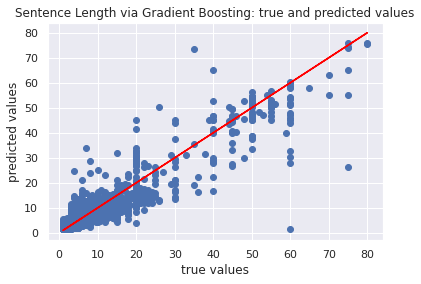

In [ ]:
print("R-squared of the model is: {}".format(r_gb**2))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, best_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, best_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, best_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - best_preds) / y_test)) * 100))

plt.scatter(y_test, best_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Sentence Length via Gradient Boosting: true and predicted values")
plt.show()

In [ ]:
GBR_perf = ['Gradient Boosting',r**2,1-((1-r**2)*(n-1)/(n-k-1)),mean_absolute_error(y_test, y_test_preds),mse(y_test, y_test_preds),rmse(y_test, y_test_preds),np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100]

In [ ]:
performance.loc[9] = GBR_perf

In [ ]:
performance

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE,MAPE
0,OLS,0.850854,0.850553,1.882381,11.345774,3.368349,34.651131
1,OLS_Lasso,0.849018,0.848714,1.898721,11.482291,3.388553,35.141133
2,OLS_Ridge,0.850811,0.850510,1.882434,11.345911,3.368369,34.654393
3,OLS_ElasticNet,0.849018,0.848714,1.898721,11.482291,3.388553,35.141133
4,KNN,0.824494,0.824140,1.951947,13.371396,3.656692,36.381160
5,Weighted KNN,0.826747,0.826398,1.969187,13.192643,3.632168,36.599671
6,Decision Tree,0.838737,0.838412,1.877050,12.279479,3.504209,36.602882
7,Random Forest,0.847874,0.847567,1.888816,11.600444,3.405942,34.113932
8,Support Vector Regression,0.852194,0.851896,1.875320,11.290460,3.360128,34.724327
9,Gradient Boosting,0.852194,0.851896,1.875320,11.290460,3.360128,34.724327


##Tuned Gradient Boosting


In [ ]:
# Initialize and fit the model.

tgbr = ensemble.GradientBoostingRegressor(n_estimators=50, max_depth=3)
tgbr.fit(X_train, y_train)

y_test_preds = tgbr.predict(X_test)
r, p_val = stats.pearsonr(y_test, y_test_preds)

Again, I used gridsearch to tune the parameters - I was trying to optimize for the best R^2 values, which may be a compromise for the error terms.

R-squared of the model is: 0.8686306057613039
Mean absolute error of the prediction is: 1.8243541604448537
Mean squared error of the prediction is: 10.070657044602827
Root mean squared error of the prediction is: 3.173429854999607
Mean absolute percentage error of the prediction is: 37.73729462770831


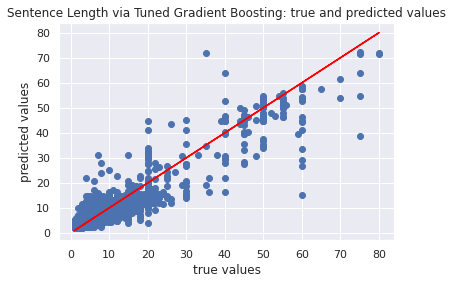

In [ ]:
print("R-squared of the model is: {}".format(r**2))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100))

plt.scatter(y_test, y_test_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Sentence Length via Tuned Gradient Boosting: true and predicted values")
plt.show()

In [ ]:
TGBR_perf = ['Tuned Gradient Boosting',r**2,1-((1-r**2)*(n-1)/(n-k-1)),mean_absolute_error(y_test, y_test_preds),mse(y_test, y_test_preds),rmse(y_test, y_test_preds),np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100]

In [ ]:
performance.loc[10] = TGBR_perf

In [ ]:
performance

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE,MAPE
0,OLS,0.850854,0.850553,1.882381,11.345774,3.368349,34.651131
1,OLS_Lasso,0.849018,0.848714,1.898721,11.482291,3.388553,35.141133
2,OLS_Ridge,0.850811,0.850510,1.882434,11.345911,3.368369,34.654393
3,OLS_ElasticNet,0.849018,0.848714,1.898721,11.482291,3.388553,35.141133
4,KNN,0.824494,0.824140,1.951947,13.371396,3.656692,36.381160
5,Weighted KNN,0.826747,0.826398,1.969187,13.192643,3.632168,36.599671
6,Decision Tree,0.838737,0.838412,1.877050,12.279479,3.504209,36.602882
7,Random Forest,0.847874,0.847567,1.888816,11.600444,3.405942,34.113932
8,Support Vector Regression,0.852194,0.851896,1.875320,11.290460,3.360128,34.724327
9,Gradient Boosting,0.852194,0.851896,1.875320,11.290460,3.360128,34.724327


#Comparing Models

In [ ]:
from sklearn.model_selection import cross_val_score

'''score_lr = cross_val_score(lrm, X_test, y_test, cv=5)
print("Linear Regression R^2: %0.4f (+/- %0.4f)" % (score_lr.mean(), score_lr.std() * 2))
score_Lasso = cross_val_score(lasso_cv, X_test, y_test, cv=5)
print("Lasso R^2: %0.4f (+/- %0.4f)" % (score_Lasso.mean(), score_Lasso.std() * 2))
score_Ridge = cross_val_score(ridge_cv, X_test, y_test, cv=5)
print("Ridge R^2: %0.4f (+/- %0.4f)" % (score_Ridge.mean(), score_Ridge.std() * 2))
score_EN = cross_val_score(EN_cv, X_test, y_test, cv=5)
print("Elastic Net R^2: %0.4f (+/- %0.4f)" % (score_EN.mean(), score_EN.std() * 2))
score_KNN = cross_val_score(knn, X_test, y_test, cv=5)
print("Unweighted KNN R^2: %0.4f (+/- %0.4f)" % (score_KNN.mean(), score_KNN.std() * 2))
score_KNNw = cross_val_score(knn_w, X_test, y_test, cv=5)
print("Weighted KNN R^2: %0.4f (+/- %0.4f)" % (score_KNNw.mean(), score_KNNw.std() * 2))
score_DT = cross_val_score(decision_tree, X_test, y_test, cv=5)
print("Decision Tree R^2: %0.4f (+/- %0.4f)" % (score_DT.mean(), score_DT.std() * 2))
score_RF = cross_val_score(rfr, X_test, y_test, cv=5)
print("Random Forest R^2: %0.4f (+/- %0.4f)" % (score_RF.mean(), score_RF.std() * 2))
score_svr = cross_val_score(svr, X_test, y_test, cv=5)
print("SVR R^2: %0.4f (+/- %0.4f)" % (score_svr.mean(), score_svr.std() * 2))
score_gbr = cross_val_score(gbr, X_test, y_test, cv=5)
print("Gradient Boost R^2: %0.4f (+/- %0.4f)" % (score_gbr.mean(), score_gbr.std() * 2))
score_tgbr = cross_val_score(tgbr, X_test, y_test, cv=5)
print("Tuned Gradient Boost R^2: %0.4f (+/- %0.4f)" % (score_tgbr.mean(), score_tgbr.std() * 2))'''

'score_lr = cross_val_score(lrm, X_test, y_test, cv=5)\nprint("Linear Regression R^2: %0.4f (+/- %0.4f)" % (score_lr.mean(), score_lr.std() * 2))\nscore_Lasso = cross_val_score(lasso_cv, X_test, y_test, cv=5)\nprint("Lasso R^2: %0.4f (+/- %0.4f)" % (score_Lasso.mean(), score_Lasso.std() * 2))\nscore_Ridge = cross_val_score(ridge_cv, X_test, y_test, cv=5)\nprint("Ridge R^2: %0.4f (+/- %0.4f)" % (score_Ridge.mean(), score_Ridge.std() * 2))\nscore_EN = cross_val_score(EN_cv, X_test, y_test, cv=5)\nprint("Elastic Net R^2: %0.4f (+/- %0.4f)" % (score_EN.mean(), score_EN.std() * 2))\nscore_KNN = cross_val_score(knn, X_test, y_test, cv=5)\nprint("Unweighted KNN R^2: %0.4f (+/- %0.4f)" % (score_KNN.mean(), score_KNN.std() * 2))\nscore_KNNw = cross_val_score(knn_w, X_test, y_test, cv=5)\nprint("Weighted KNN R^2: %0.4f (+/- %0.4f)" % (score_KNNw.mean(), score_KNNw.std() * 2))\nscore_DT = cross_val_score(decision_tree, X_test, y_test, cv=5)\nprint("Decision Tree R^2: %0.4f (+/- %0.4f)" % (score_D

This originally cross validated for R^2 values, but I have built a different dataframe to compare models below.

In [ ]:
mean_sentence_length = final_df['Sentence Length'].mean()

In [ ]:
performance_cv = performance.copy()

In [ ]:
model_list=[lrm,lasso_cv,ridge_cv,EN_cv,knn,knn_w,decision_tree,rfr,svr,gbr,tgbr]

In [ ]:
sd_list = [[2, 'R^2 SD', 0],[4, 'Adjusted R^2 SD', 0],[6, 'MAE SD', 0],[8, 'MSE SD', 0],[10, 'RMSE SD', 0],[12, 'MAPE SD', 0]]
for i in sd_list:
  performance_cv.insert(i[0],i[1],i[2])

In [ ]:
model_names = ['OLS', 'OLS_Lasso','OLS_Ridge','OLS_ElasticNet','KNN','Weighted KNN','Decision Tree','Random Forest','Support Vector Regression', 'Gradient Boosting','Tuned Gradient Boosting']

for i in range(len(model_list)):

  r2 = cross_val_score(model_list[i], X_test, y_test, cv=5)
  ar2 = cross_val_score(model_list[i], X_test, y_test, cv=5)
  mae = cross_val_score(model_list[i], X_test, y_test, scoring="neg_mean_absolute_error", cv=5)
  mse = cross_val_score(model_list[i], X_test, y_test, scoring="neg_mean_squared_error", cv=5)
  rmse = cross_val_score(model_list[i], X_test, y_test, scoring="neg_root_mean_squared_error", cv=5)

  model_perf = [model_names[i], r2.mean(), r2.std(),
                1-((1-ar2.mean())*(n-1)/(n-k-1)), 1-((1-ar2.std())*(n-1)/(n-k-1)),
                -1*mae.mean(), mae.std(),
                -1*mse.mean(), mse.std(),
                -1*rmse.mean(), rmse.std(),
                -1*mae.mean()/mean_sentence_length, mae.std()/mean_sentence_length]

  performance_cv.loc[i] = model_perf

In [ ]:
performance_cv

,Model,R^2,R^2 SD,Adjusted R^2,Adjusted R^2 SD,MAE,MAE SD,MSE,MSE SD,RMSE,RMSE SD,MAPE,MAPE SD
0,OLS,0.848392,0.014447,0.848086,0.012459,1.923286,0.105715,11.557363,2.171079,3.384792,0.317094,0.292038,0.016052
1,OLS_Lasso,0.848390,0.017845,0.848084,0.015864,1.929489,0.122716,11.550021,2.273068,3.382005,0.334763,0.292980,0.018634
2,OLS_Ridge,0.848365,0.015844,0.848059,0.013859,1.925743,0.110376,11.551587,2.179684,3.383623,0.320443,0.292411,0.016760
3,OLS_ElasticNet,0.848710,0.017624,0.848405,0.015643,1.930939,0.118703,11.524340,2.251103,3.378465,0.332135,0.293200,0.018024
4,KNN,0.797094,0.022733,0.796685,0.020762,2.120258,0.128542,15.453263,3.065345,3.913327,0.373012,0.321947,0.019518
5,Weighted KNN,0.805335,0.022100,0.804942,0.020128,2.090449,0.123762,14.839659,3.021178,3.833808,0.376267,0.317420,0.018792
6,Decision Tree,0.813933,0.022028,0.810269,0.024827,1.967942,0.122179,14.502916,2.858480,3.771036,0.364823,0.298818,0.018552
7,Random Forest,0.847234,0.011840,0.847016,0.009514,1.876760,0.094682,11.583667,1.780655,3.358820,0.232975,0.284973,0.014377
8,Support Vector Regression,0.834657,0.021907,0.834323,0.019935,1.976256,0.143663,12.722528,3.219792,3.539520,0.440824,0.300081,0.021814
9,Gradient Boosting,0.866811,0.007045,0.866594,0.005395,1.785200,0.089328,10.078006,1.420049,3.167147,0.212384,0.271070,0.013564


We can see the Gradient Boosting seemed to have the most prediction success - highest R^2 with the lowest error values. But lets visualize that.

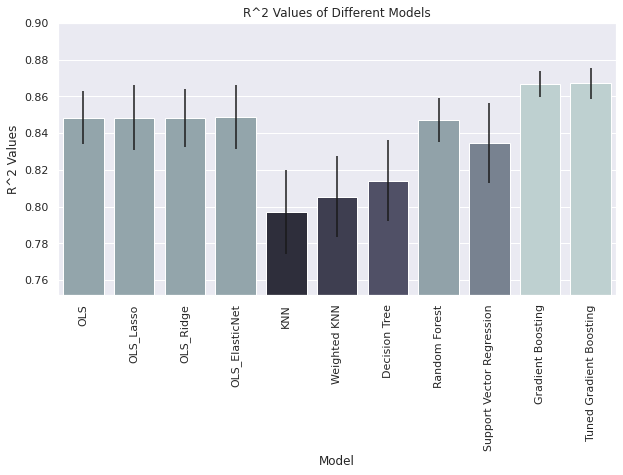

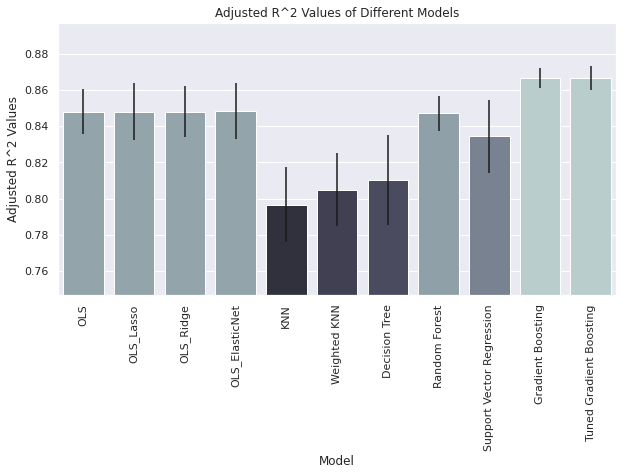

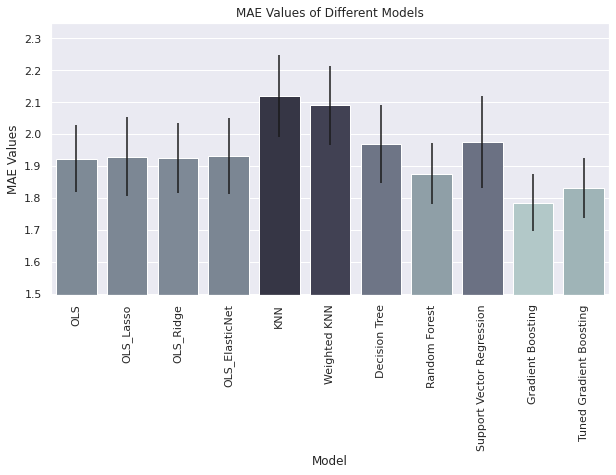

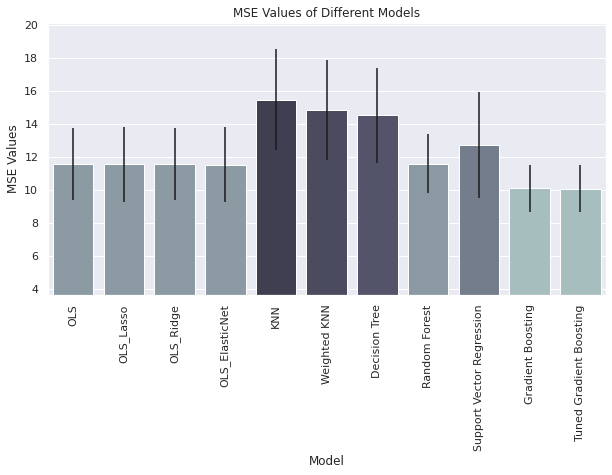

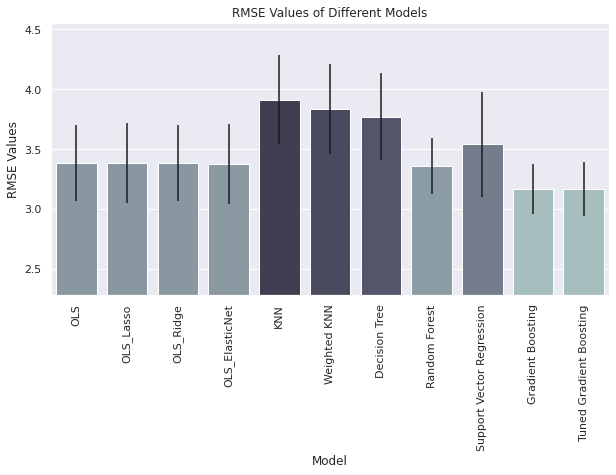

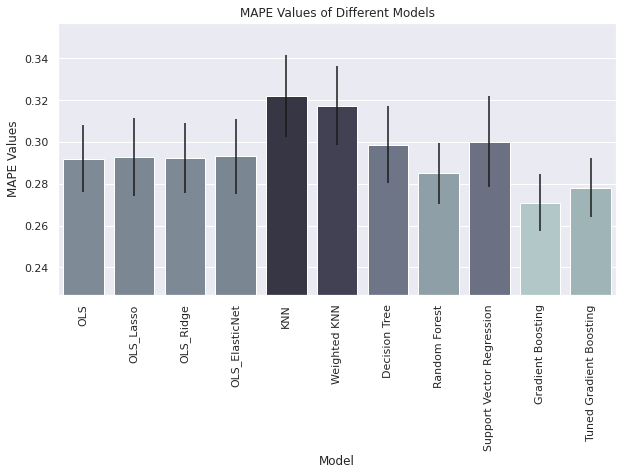

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

for i in range(1,12,2):
  
  col = performance_cv.columns[i]
  sd_col = performance_cv.columns[i+1]

  vals = performance_cv[col]
  vals_sd = performance_cv[sd_col]
  mdls = performance_cv['Model']

  norm = plt.Normalize(vals.values.min()-vals_sd.values.max(), vals.values.max()+vals_sd.values.max())

  if i<5:
    colors = plt.cm.bone(norm(vals))
  else:
    colors = plt.cm.bone_r(norm(vals))

  plt.figure(figsize=(10,5))

  ax = sns.barplot(y=vals, x=mdls, yerr=vals_sd, palette=colors)
  plt.ylabel('{} Values'.format(col))
  plt.title('{} Values of Different Models'.format(col))
  plt.xticks(rotation=90)
  plt.ylim(round(vals.values.min()-2*vals_sd.values.max(),3),round(vals.values.max()+2*vals_sd.values.mean(),3))

  plt.show()

Here we can see how Gradient Boosting was the best model for predicting Sentence Length.

#Looking at a Reduced Model: No Personal Data

In [ ]:
basic_features = []

for i in range(12,20):
  basic_features.append(new_df.columns[i])

In [ ]:
basic_features

['AT: First Offense',
 'AT: Discharged & Recommitted',
 'AT: Parole Violation',
 'Class 1 Felony',
 'Class 2 Felony',
 'Class 3 Felony',
 'Class X Felony',
 'Murder Felony']

These are what I am defining as the 'basic' features - these are the features which contain no personal information. There is no racial data, no age data, and no residence data.

By looking at this, we can assess whether or not personal data is taken into account when people are being sentenced, which would speak to personal bias in sentencing. Let's run the same models, this time with the basic features.

##Linear Regression with OLS


In [ ]:
Y = final_df['Sentence Length']
X = final_df[basic_features]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

In [ ]:
lrm = linear_model.LinearRegression()
lrm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

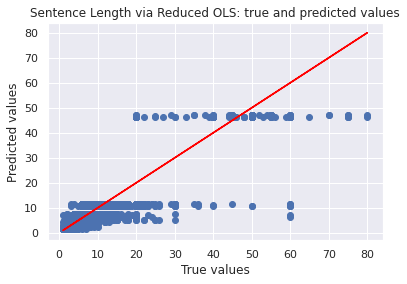

In [ ]:
reduced_pred = lrm.predict(X_test)
rr, p_val = stats.pearsonr(y_test, reduced_pred)

plt.scatter(y_test, reduced_pred)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Sentence Length via Reduced OLS: true and predicted values")
plt.show()

###Regularization

In [ ]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [ ]:
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

LassoCV(alphas=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0,
                10000000.0, 100000000.0, 1000000000.0, 10000000000.0,
                100000000000.0, 1000000000000.0, 10000000000000.0,
                100000000000000.0, 1000000000000000.0, 1e+16, 1e+17, 1e+18,
                1e+19, ...],
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

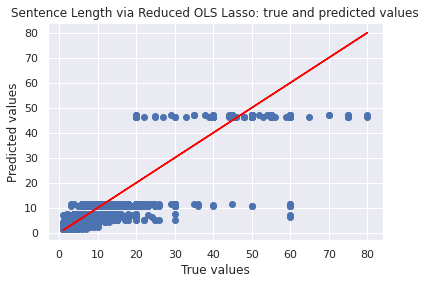

In [ ]:
reduced_pred = lasso_cv.predict(X_test)
rr, p_val = stats.pearsonr(y_test, reduced_pred)

plt.scatter(y_test, reduced_pred)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Sentence Length via Reduced OLS Lasso: true and predicted values")
plt.show()

In [ ]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10, 1.e+11, 1.e+12, 1.e+13,
       1.e+14, 1.e+15, 1.e+16, 1.e+17, 1.e+18, 1.e+19, 1.e+20, 1.e+21,
       1.e+22, 1.e+23, 1.e+24, 1.e+25, 1.e+26, 1.e+27, 1.e+28, 1.e+29,
       1.e+30, 1.e+31, 1.e+32, 1.e+33, 1.e+34, 1.e+35, 1.e+36, 1.e+37,
       1.e+38, 1.e+39]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

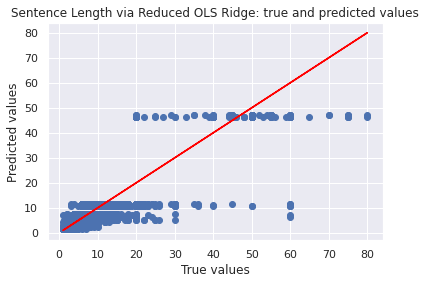

In [ ]:
reduced_pred = ridge_cv.predict(X_test)
rr, p_val = stats.pearsonr(y_test, reduced_pred)

plt.scatter(y_test, reduced_pred)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Sentence Length via Reduced OLS Ridge: true and predicted values")
plt.show()

In [ ]:
EN_cv = ElasticNetCV(alphas=alphas, cv=5)
EN_cv.fit(X_train, y_train)

ElasticNetCV(alphas=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                     0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0,
                     1000000.0, 10000000.0, 100000000.0, 1000000000.0,
                     10000000000.0, 100000000000.0, 1000000000000.0,
                     10000000000000.0, 100000000000000.0, 1000000000000000.0,
                     1e+16, 1e+17, 1e+18, 1e+19, ...],
             copy_X=True, cv=5, eps=0.001, fit_intercept=True, l1_ratio=0.5,
             max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
             positive=False, precompute='auto', random_state=None,
             selection='cyclic', tol=0.0001, verbose=0)

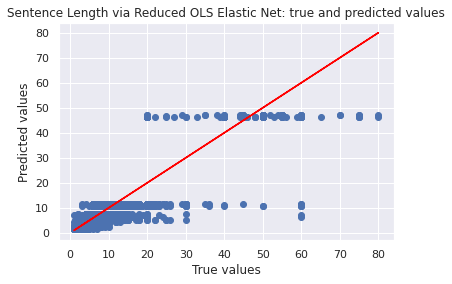

In [ ]:
reduced_pred = EN_cv.predict(X_test)
rr, p_val = stats.pearsonr(y_test, reduced_pred)

plt.scatter(y_test, reduced_pred)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Sentence Length via Reduced OLS Elastic Net: true and predicted values")
plt.show()

##KNN Regression

###Unweighted

In [ ]:
knn = neighbors.KNeighborsRegressor(n_neighbors=9)
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                    weights='uniform')

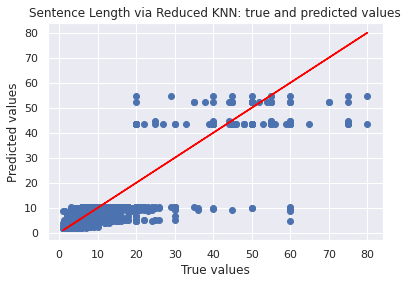

In [ ]:
reduced_pred = knn.predict(X_test)
rr, p_val = stats.pearsonr(y_test, reduced_pred)

plt.scatter(y_test, reduced_pred)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Sentence Length via Reduced KNN: true and predicted values")
plt.show()

###Weighted

In [ ]:
knn_w = neighbors.KNeighborsRegressor(n_neighbors=9, weights='distance')
knn_w.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                    weights='distance')

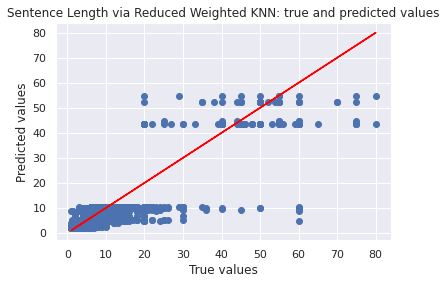

In [ ]:
reduced_pred = knn_w.predict(X_test)
rr, p_val = stats.pearsonr(y_test, reduced_pred)

plt.scatter(y_test, reduced_pred)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Sentence Length via Reduced Weighted KNN: true and predicted values")
plt.show()

##Decision Tree

In [ ]:
decision_tree = tree.DecisionTreeRegressor(max_depth=7)
decision_tree.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

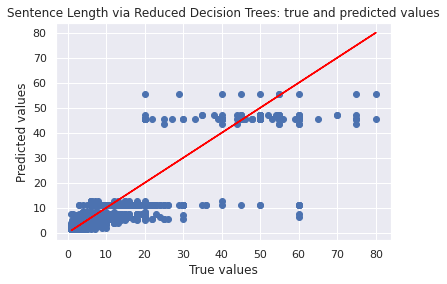

In [ ]:
reduced_pred = decision_tree.predict(X_test)
rr, p_val = stats.pearsonr(y_test, reduced_pred)

plt.scatter(y_test, reduced_pred)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Sentence Length via Reduced Decision Trees: true and predicted values")
plt.show()

##Random Forest

In [ ]:
rfr = ensemble.RandomForestRegressor()
rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

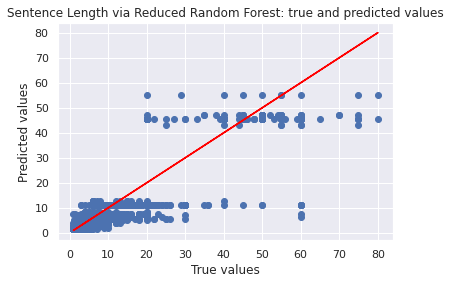

In [ ]:
reduced_pred = rfr.predict(X_test)
rr, p_val = stats.pearsonr(y_test, reduced_pred)

plt.scatter(y_test, reduced_pred)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Sentence Length via Reduced Random Forest: true and predicted values")
plt.show()

##Support Vector Regression

In [ ]:
svr = SVR(epsilon=1,C=1000000)
svr.fit(X_train,y_train)

SVR(C=1000000, cache_size=200, coef0=0.0, degree=3, epsilon=1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

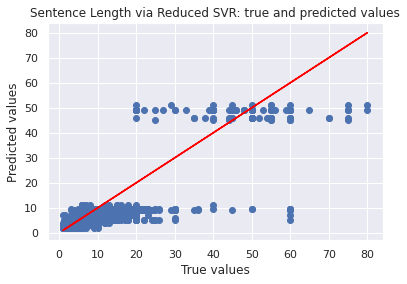

In [ ]:
reduced_pred = svr.predict(X_test)
rr, p_val = stats.pearsonr(y_test, reduced_pred)

plt.scatter(y_test, reduced_pred)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Sentence Length via Reduced SVR: true and predicted values")
plt.show()

##Gradient Boosting

In [ ]:
gbr = ensemble.GradientBoostingRegressor()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

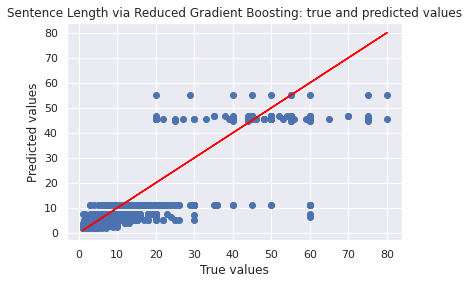

In [ ]:
reduced_pred = gbr.predict(X_test)
rr, p_val = stats.pearsonr(y_test, reduced_pred)

plt.scatter(y_test, reduced_pred)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Sentence Length via Reduced Gradient Boosting: true and predicted values")
plt.show()

##Tuned Gradient Boosting


In [ ]:
tgbr = ensemble.GradientBoostingRegressor(n_estimators=50, max_depth=3)
tgbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

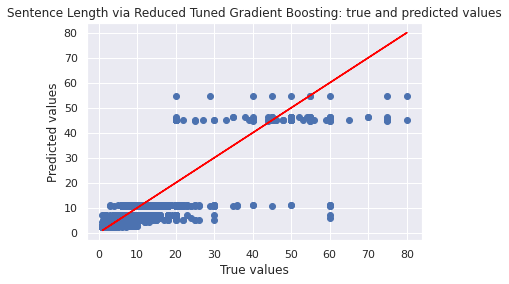

In [ ]:
reduced_pred = tgbr.predict(X_test)
rr, p_val = stats.pearsonr(y_test, reduced_pred)

plt.scatter(y_test, reduced_pred)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Sentence Length via Reduced Tuned Gradient Boosting: true and predicted values")
plt.show()

##Comparing Full and Reduced Models

In [ ]:
score_lr = cross_val_score(lrm, X_test, y_test, cv=5)
print("Linear Regression R^2: %0.4f (+/- %0.4f)" % (score_lr.mean(), score_lr.std() * 2))
score_Lasso = cross_val_score(lasso_cv, X_test, y_test, cv=5)
print("Lasso R^2: %0.4f (+/- %0.4f)" % (score_Lasso.mean(), score_Lasso.std() * 2))
score_Ridge = cross_val_score(ridge_cv, X_test, y_test, cv=5)
print("Ridge R^2: %0.4f (+/- %0.4f)" % (score_Ridge.mean(), score_Ridge.std() * 2))
score_EN = cross_val_score(EN_cv, X_test, y_test, cv=5)
print("Elastic Net R^2: %0.4f (+/- %0.4f)" % (score_EN.mean(), score_EN.std() * 2))
score_KNN = cross_val_score(knn, X_test, y_test, cv=5)
print("Unweighted KNN R^2: %0.4f (+/- %0.4f)" % (score_KNN.mean(), score_KNN.std() * 2))
score_KNNw = cross_val_score(knn_w, X_test, y_test, cv=5)
print("Weighted KNN R^2: %0.4f (+/- %0.4f)" % (score_KNNw.mean(), score_KNNw.std() * 2))
score_DT = cross_val_score(decision_tree, X_test, y_test, cv=5)
print("Decision Tree R^2: %0.4f (+/- %0.4f)" % (score_DT.mean(), score_DT.std() * 2))
score_RF = cross_val_score(rfr, X_test, y_test, cv=5)
print("Random Forest R^2: %0.4f (+/- %0.4f)" % (score_RF.mean(), score_RF.std() * 2))
score_svr = cross_val_score(svr, X_test, y_test, cv=5)
print("SVR R^2: %0.4f (+/- %0.4f)" % (score_svr.mean(), score_svr.std() * 2))
score_gbr = cross_val_score(gbr, X_test, y_test, cv=5)
print("Gradient Boost R^2: %0.4f (+/- %0.4f)" % (score_gbr.mean(), score_gbr.std() * 2))
score_tgbr = cross_val_score(tgbr, X_test, y_test, cv=5)
print("Tuned Gradient Boost R^2: %0.4f (+/- %0.4f)" % (score_tgbr.mean(), score_tgbr.std() * 2))

Linear Regression R^2: 0.7304 (+/- 0.0707)
Lasso R^2: 0.7304 (+/- 0.0707)
Ridge R^2: 0.7304 (+/- 0.0706)
Elastic Net R^2: 0.7303 (+/- 0.0707)
Unweighted KNN R^2: 0.6743 (+/- 0.1114)
Weighted KNN R^2: 0.6877 (+/- 0.1100)
Decision Tree R^2: 0.7333 (+/- 0.0795)
Random Forest R^2: 0.7333 (+/- 0.0793)
SVR R^2: 0.7227 (+/- 0.0796)
Gradient Boost R^2: 0.7340 (+/- 0.0784)
Tuned Gradient Boost R^2: 0.7325 (+/- 0.0796)


Taking a look at these cross validated R^2 values, it seems like these models are a lot less accurate than those with personal data. Lets take a deeper look.

In [ ]:
def insert_row(row_number, df, row_value): 
    df1 = df[0:row_number] 
    final_df = df[row_number:] 
    df1.loc[row_number]=row_value 
    df_result = pd.concat([df1, final_df]) 
    df_result.index = [*range(df_result.shape[0])] 
    return df_result 

In [ ]:
performance_cv

,Model,R^2,R^2 SD,Adjusted R^2,Adjusted R^2 SD,MAE,MAE SD,MSE,MSE SD,RMSE,RMSE SD,MAPE,MAPE SD
0,OLS,0.848392,0.014447,0.848086,0.012459,1.923286,0.105715,11.557363,2.171079,3.384792,0.317094,0.292038,0.016052
1,OLS_Lasso,0.848390,0.017845,0.848084,0.015864,1.929489,0.122716,11.550021,2.273068,3.382005,0.334763,0.292980,0.018634
2,OLS_Ridge,0.848365,0.015844,0.848059,0.013859,1.925743,0.110376,11.551587,2.179684,3.383623,0.320443,0.292411,0.016760
3,OLS_ElasticNet,0.848710,0.017624,0.848405,0.015643,1.930939,0.118703,11.524340,2.251103,3.378465,0.332135,0.293200,0.018024
4,KNN,0.797094,0.022733,0.796685,0.020762,2.120258,0.128542,15.453263,3.065345,3.913327,0.373012,0.321947,0.019518
5,Weighted KNN,0.805335,0.022100,0.804942,0.020128,2.090449,0.123762,14.839659,3.021178,3.833808,0.376267,0.317420,0.018792
6,Decision Tree,0.813933,0.022028,0.810269,0.024827,1.967942,0.122179,14.502916,2.858480,3.771036,0.364823,0.298818,0.018552
7,Random Forest,0.847234,0.011840,0.847016,0.009514,1.876760,0.094682,11.583667,1.780655,3.358820,0.232975,0.284973,0.014377
8,Support Vector Regression,0.834657,0.021907,0.834323,0.019935,1.976256,0.143663,12.722528,3.219792,3.539520,0.440824,0.300081,0.021814
9,Gradient Boosting,0.866811,0.007045,0.866594,0.005395,1.785200,0.089328,10.078006,1.420049,3.167147,0.212384,0.271070,0.013564


In [ ]:
model_names = ['OLS R*', 'OLS_Lasso R*','OLS_Ridge R*','OLS_ElasticNet R*','KNN R*','Weighted KNN R*','Decision Tree R*','Random Forest R*','Support Vector Regression R*', 'Gradient Boosting R*','Tuned Gradient Boosting R*']

for i in range(len(model_list)):

  r2 = cross_val_score(model_list[i], X_test, y_test, cv=5)
  ar2 = cross_val_score(model_list[i], X_test, y_test, cv=5)
  mae = cross_val_score(model_list[i], X_test, y_test, scoring="neg_mean_absolute_error", cv=5)
  mse = cross_val_score(model_list[i], X_test, y_test, scoring="neg_mean_squared_error", cv=5)
  rmse = cross_val_score(model_list[i], X_test, y_test, scoring="neg_root_mean_squared_error", cv=5)

  model_perf = [model_names[i], r2.mean(), r2.std(),
                1-((1-ar2.mean())*(n-1)/(n-k-1)), 1-((1-ar2.std())*(n-1)/(n-k-1)),
                -1*mae.mean(), mae.std(),
                -1*mse.mean(), mse.std(),
                -1*rmse.mean(), rmse.std(),
                -1*mae.mean()/mean_sentence_length, mae.std()/mean_sentence_length]

  performance_cv = insert_row(2*i+1, performance_cv, model_perf)

With this visualization, we can see how the reduced model in each case is much less useful in predicting sentence length.

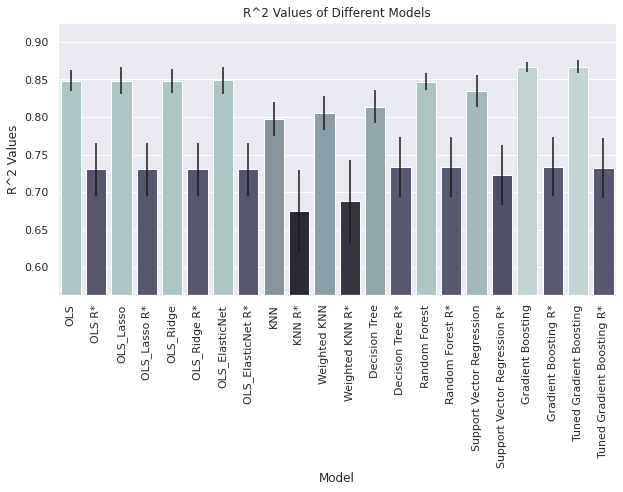

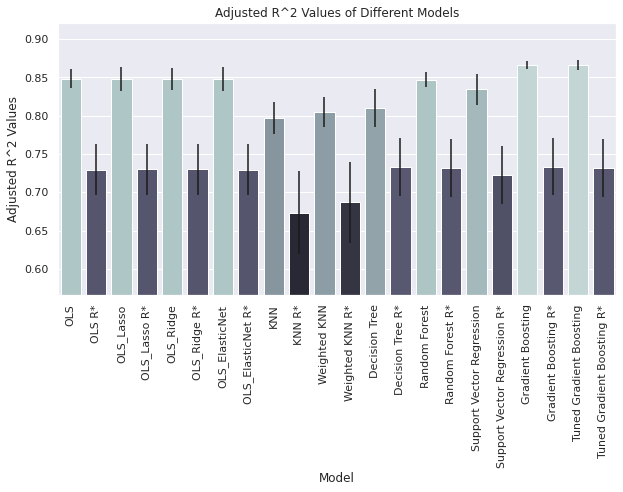

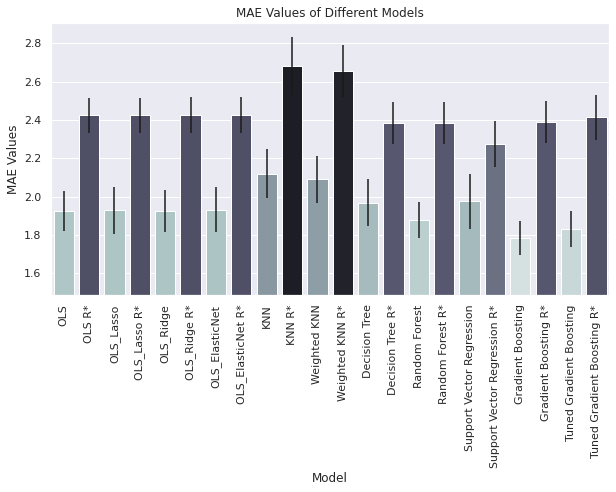

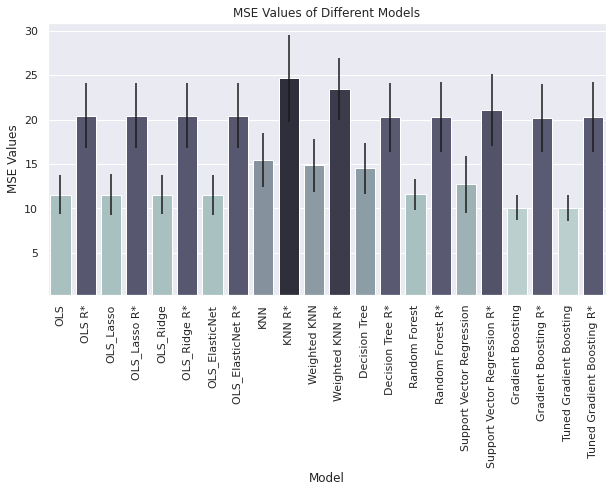

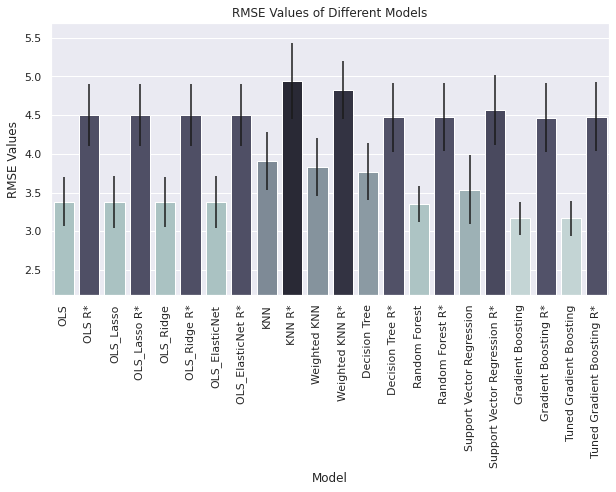

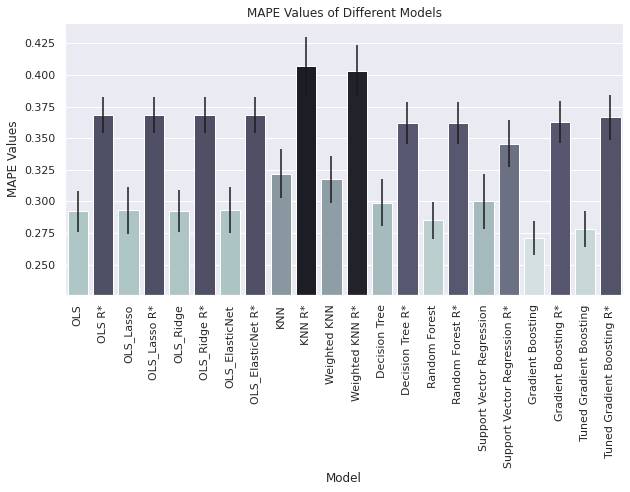

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

for i in range(1,12,2):
  
  col = performance_cv.columns[i]
  sd_col = performance_cv.columns[i+1]

  vals = performance_cv[col]
  vals_sd = performance_cv[sd_col]
  mdls = performance_cv['Model']

  norm = plt.Normalize(vals.values.min()-vals_sd.values.max(), vals.values.max()+vals_sd.values.max())

  if i<5:
    colors = plt.cm.bone(norm(vals))
  else:
    colors = plt.cm.bone_r(norm(vals))

  plt.figure(figsize=(10,5))

  ax = sns.barplot(y=vals, x=mdls, yerr=vals_sd, palette=colors)
  plt.ylabel('{} Values'.format(col))
  plt.title('{} Values of Different Models'.format(col))
  plt.xticks(rotation=90)
  plt.ylim(round(vals.values.min()-2*vals_sd.values.max(),3),round(vals.values.max()+2*vals_sd.values.mean(),3))

  plt.show()

In [ ]:
performance_cv

,Model,R^2,R^2 SD,Adjusted R^2,Adjusted R^2 SD,MAE,MAE SD,MSE,MSE SD,RMSE,RMSE SD,MAPE,MAPE SD
0,OLS,0.848392,0.014447,0.848086,0.012459,1.923286,0.105715,11.557363,2.171079,3.384792,0.317094,0.292038,0.016052
1,OLS R*,0.730353,0.035348,0.729809,0.033403,2.424906,0.092160,20.441372,3.618648,4.503001,0.405410,0.368205,0.013994
2,OLS_Lasso,0.848390,0.017845,0.848084,0.015864,1.929489,0.122716,11.550021,2.273068,3.382005,0.334763,0.292980,0.018634
3,OLS_Lasso R*,0.730412,0.035334,0.729869,0.033388,2.425235,0.091986,20.437311,3.620269,4.502531,0.405614,0.368255,0.013967
4,OLS_Ridge,0.848365,0.015844,0.848059,0.013859,1.925743,0.110376,11.551587,2.179684,3.383623,0.320443,0.292411,0.016760
5,OLS_Ridge R*,0.730387,0.035314,0.729844,0.033368,2.426665,0.093313,20.439444,3.620505,4.502769,0.405608,0.368472,0.014169
6,OLS_ElasticNet,0.848710,0.017624,0.848405,0.015643,1.930939,0.118703,11.524340,2.251103,3.378465,0.332135,0.293200,0.018024
7,OLS_ElasticNet R*,0.730345,0.035331,0.729801,0.033386,2.425131,0.092313,20.442393,3.620004,4.503101,0.405558,0.368240,0.014017
8,KNN,0.797094,0.022733,0.796685,0.020762,2.120258,0.128542,15.453263,3.065345,3.913327,0.373012,0.321947,0.019518
9,KNN R*,0.674279,0.055688,0.673622,0.053784,2.681200,0.149748,24.640945,4.894116,4.939365,0.493573,0.407122,0.022738


In [ ]:
Reduced = performance_cv[performance_cv['R^2']<0.75]
Original = performance_cv[performance_cv['R^2']>0.75]

In [ ]:
Reduced

,Model,R^2,R^2 SD,Adjusted R^2,Adjusted R^2 SD,MAE,MAE SD,MSE,MSE SD,RMSE,RMSE SD,MAPE,MAPE SD
1,OLS R*,0.730353,0.035348,0.729809,0.033403,2.424906,0.092160,20.441372,3.618648,4.503001,0.405410,0.368205,0.013994
3,OLS_Lasso R*,0.730412,0.035334,0.729869,0.033388,2.425235,0.091986,20.437311,3.620269,4.502531,0.405614,0.368255,0.013967
5,OLS_Ridge R*,0.730387,0.035314,0.729844,0.033368,2.426665,0.093313,20.439444,3.620505,4.502769,0.405608,0.368472,0.014169
7,OLS_ElasticNet R*,0.730345,0.035331,0.729801,0.033386,2.425131,0.092313,20.442393,3.620004,4.503101,0.405558,0.368240,0.014017
9,KNN R*,0.674279,0.055688,0.673622,0.053784,2.681200,0.149748,24.640945,4.894116,4.939365,0.493573,0.407122,0.022738
11,Weighted KNN R*,0.687722,0.054986,0.687093,0.053080,2.656295,0.133972,23.443562,3.517249,4.827217,0.376214,0.403340,0.020343
13,Decision Tree R*,0.733300,0.039765,0.732762,0.037829,2.385819,0.109732,20.230597,3.899187,4.475840,0.444360,0.362270,0.016662
15,Random Forest R*,0.733438,0.039945,0.732016,0.037968,2.384508,0.107450,20.263428,3.924002,4.478362,0.442906,0.362071,0.016316
17,Support Vector Regression R*,0.722670,0.039799,0.722111,0.037862,2.276073,0.121170,21.048490,4.020961,4.565742,0.449992,0.345606,0.018399
19,Gradient Boosting R*,0.733962,0.039207,0.733425,0.037269,2.388963,0.108846,20.179617,3.859948,4.470521,0.440517,0.362748,0.016528


In [ ]:
Reduced

,Model,R^2,R^2 SD,Adjusted R^2,Adjusted R^2 SD,MAE,MAE SD,MSE,MSE SD,RMSE,RMSE SD,MAPE,MAPE SD
1,OLS R*,0.730353,0.035348,0.729809,0.033403,2.424906,0.092160,20.441372,3.618648,4.503001,0.405410,0.368205,0.013994
3,OLS_Lasso R*,0.730412,0.035334,0.729869,0.033388,2.425235,0.091986,20.437311,3.620269,4.502531,0.405614,0.368255,0.013967
5,OLS_Ridge R*,0.730387,0.035314,0.729844,0.033368,2.426665,0.093313,20.439444,3.620505,4.502769,0.405608,0.368472,0.014169
7,OLS_ElasticNet R*,0.730345,0.035331,0.729801,0.033386,2.425131,0.092313,20.442393,3.620004,4.503101,0.405558,0.368240,0.014017
9,KNN R*,0.674279,0.055688,0.673622,0.053784,2.681200,0.149748,24.640945,4.894116,4.939365,0.493573,0.407122,0.022738
11,Weighted KNN R*,0.687722,0.054986,0.687093,0.053080,2.656295,0.133972,23.443562,3.517249,4.827217,0.376214,0.403340,0.020343
13,Decision Tree R*,0.733300,0.039765,0.732762,0.037829,2.385819,0.109732,20.230597,3.899187,4.475840,0.444360,0.362270,0.016662
15,Random Forest R*,0.733438,0.039945,0.732016,0.037968,2.384508,0.107450,20.263428,3.924002,4.478362,0.442906,0.362071,0.016316
17,Support Vector Regression R*,0.722670,0.039799,0.722111,0.037862,2.276073,0.121170,21.048490,4.020961,4.565742,0.449992,0.345606,0.018399
19,Gradient Boosting R*,0.733962,0.039207,0.733425,0.037269,2.388963,0.108846,20.179617,3.859948,4.470521,0.440517,0.362748,0.016528


In [ ]:
Original.iloc[-2][11]

0.271070350046194

In [ ]:
Reduced.iloc[-2][11]

0.36274767623104776

In [ ]:
for i in range(1,12,2):
  print('Original was {}% better than Reduced in {}'.format(round(100*abs(1 - Original.iloc[-2][i]/Reduced.iloc[-2][i]),2),Original.columns[i]))

Original was 18.1% better than Reduced in R^2
Original was 18.16% better than Reduced in Adjusted R^2
Original was 25.27% better than Reduced in MAE
Original was 50.06% better than Reduced in MSE
Original was 29.15% better than Reduced in RMSE
Original was 25.27% better than Reduced in MAPE


In [ ]:
1 - Original.iloc[-2][11]/Reduced.iloc[-2][11]

0.25273029213414167

In [ ]:
Original.mean()/Reduced.mean()

R^2                1.162057
R^2 SD             0.403939
Adjusted R^2       1.162204
Adjusted R^2 SD    0.384264
MAE                0.794342
MAE SD             1.028742
MSE                0.584108
MSE SD             0.604096
RMSE               0.761814
RMSE SD            0.748718
MAPE               0.794342
MAPE SD            1.028742
dtype: float64

In [ ]:
Reduced.mean()/Original.mean()

R^2                0.860543
R^2 SD             2.475619
Adjusted R^2       0.860434
Adjusted R^2 SD    2.602376
MAE                1.258903
MAE SD             0.972061
MSE                1.712012
MSE SD             1.655365
RMSE               1.312656
RMSE SD            1.335616
MAPE               1.258903
MAPE SD            0.972061
dtype: float64

#Other Info

Avg age per race?
Avg sentence length per race?
Avg sentence length per sentence year? - include race as a factor?

In [ ]:
Black = final_df[final_df['Race']=='Black']
White = final_df[final_df['Race']=='White']
Hispanic = final_df[final_df['Race']=='Hispanic']

In [ ]:
print('Black Count:', Black.shape[0]/final_df.shape[0])
print('White Count:', White.shape[0]/final_df.shape[0])
print('Hispanic Count:', Hispanic.shape[0]/final_df.shape[0])

Black Count: 0.5336492096104658
White Count: 0.32609333724684475
Hispanic Count: 0.13090695626651014


In [ ]:
print('Black Count:', Black.shape[0])
print('White Count:', White.shape[0])
print('Hispanic Count:', Hispanic.shape[0])

Black Count: 12727
White Count: 7777
Hispanic Count: 3122


In [ ]:
print('Black Mean Age at Sentencing:', Black['Age at Sentencing'].mean())
print('White Mean Age at Sentencing:', White['Age at Sentencing'].mean())
print('Hispanic Mean Age at Sentencing:', Hispanic['Age at Sentencing'].mean())
print('\n')
print('Black Median Age at Sentencing:', Black['Age at Sentencing'].median())
print('White Median Age at Sentencing:', White['Age at Sentencing'].median())
print('Hispanic Median Age at Sentencing:', Hispanic['Age at Sentencing'].median())

Black Mean Age at Sentencing: 33.275909483774775
White Mean Age at Sentencing: 35.90134370579899
Hispanic Mean Age at Sentencing: 32.888639760836995


Black Median Age at Sentencing: 30.5
White Median Age at Sentencing: 34.25
Hispanic Median Age at Sentencing: 30.791666666666664


In [ ]:
print('Black vs. White p-value:',stats.kruskal(Black['Age at Sentencing'], White['Age at Sentencing'])[1])
print('Hispanic vs. White p-value:',stats.kruskal(Hispanic['Age at Sentencing'], White['Age at Sentencing'])[1])

Black vs. White p-value: 2.8745972250352005e-91
Hispanic vs. White p-value: 2.7860702247118766e-47


In [ ]:
print('On average, Black people were sentenced at {} years younger than White people, and Hispanic people were sentenced at {} years younger than White people.'.format(round(White['Age at Sentencing'].mean()-Black['Age at Sentencing'].mean(),3),round(White['Age at Sentencing'].mean()-Hispanic['Age at Sentencing'].mean(),3)))

On average, Black people were sentenced at 2.625 years younger than White people, and Hispanic people were sentenced at 3.013 years younger than White people.


This difference is proven as statistically significant.

In [ ]:
print('Black Mean Sentence Length:', Black['Sentence Length'].mean())
print('White Mean Sentence Length:', White['Sentence Length'].mean())
print('Hispanic Mean Sentence Length:', Hispanic['Sentence Length'].mean())
print('\n')
print('Black Median SL:', Black['Sentence Length'].median())
print('White Median sL:', White['Sentence Length'].median())
print('Hispanic Median SL:', Hispanic['Sentence Length'].median())

Black Mean Sentence Length: 7.307666116654879
White Mean Sentence Length: 5.256172045776005
Hispanic Mean Sentence Length: 7.0837337177023265


Black Median SL: 4.666666666666667
White Median sL: 4.0
Hispanic Median SL: 5.0


In [ ]:
print('Black vs. White p-value:',stats.kruskal(Black['Sentence Length'], White['Sentence Length'])[1])
print('Hispanic vs. White p-value:',stats.kruskal(Hispanic['Sentence Length'], White['Sentence Length'])[1])

Black vs. White p-value: 2.728284443874141e-68
Hispanic vs. White p-value: 1.6147382671788015e-64


In [ ]:
print('On average, Black people were sentenced for {} more years than White people, and Hispanic people were sentenced for {} more years than White people.'.format(round(abs(White['Sentence Length'].mean()-Black['Sentence Length'].mean()),3),round(abs(White['Sentence Length'].mean()-Hispanic['Sentence Length'].mean()),3)))

On average, Black people were sentenced for 2.051 more years than White people, and Hispanic people were sentenced for 1.828 more years than White people.


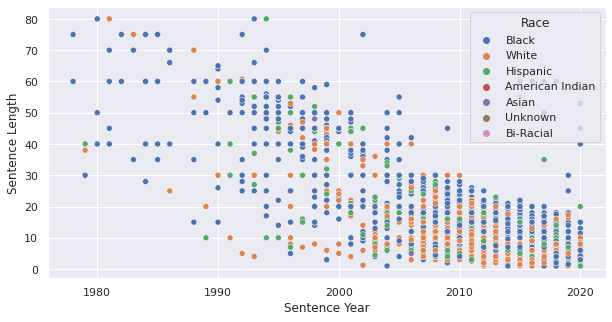

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='Sentence Year', y='Sentence Length', data=final_df, hue='Race')

Here is a visualization of that data collection bias I mentioned earlier - seeing as how the data was gathered, the longer sentences on average are from an earlier sentence year.

#Conclusions and Discussion

After gathering the data, we were able to clean it up and prepare it for modeling. We worked through multiple different models and were able to create a predictive algorithm for incarceration sentence length based on a few important features. We utilized various OLS methods - including three different types of regularization, weighted and unweighted KNN, decision trees, random forests, support vector machines, and gradient boosting. After building all of those models, we found that Gradient Boosting was the most accurate predictive model, with the highest test R^2 and lowest testing errors.

Our final Gradient Boosting Model ended up looking something like this: 

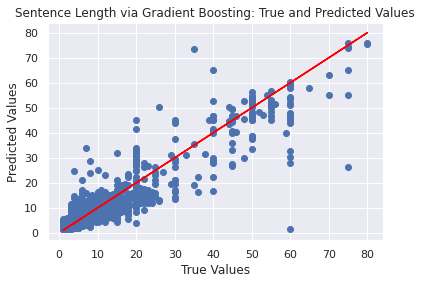

In [ ]:
plt.scatter(y_test, best_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Sentence Length via Gradient Boosting: True and Predicted Values")
plt.show()

It also had accuracy and error statistics of:

In [ ]:
performance_cv[performance_cv['Model'] == 'Gradient Boosting']

,Model,R^2,R^2 SD,Adjusted R^2,Adjusted R^2 SD,MAE,MAE SD,MSE,MSE SD,RMSE,RMSE SD,MAPE,MAPE SD
18,Gradient Boosting,0.866811,0.007045,0.866594,0.005395,1.7852,0.089328,10.078006,1.420049,3.167147,0.212384,0.27107,0.013564


After looking at the differences between the reduced models and models which included personal data, we could see that personal data played a large role in determining sentencing length.

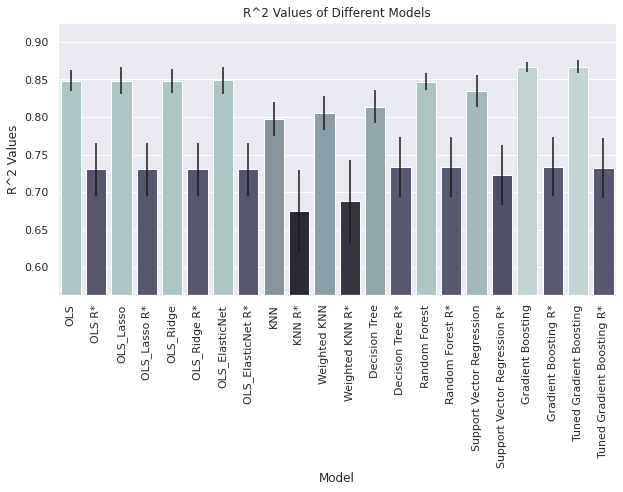

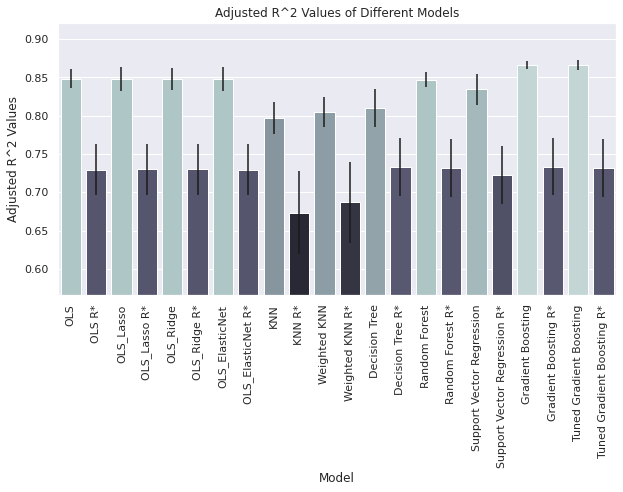

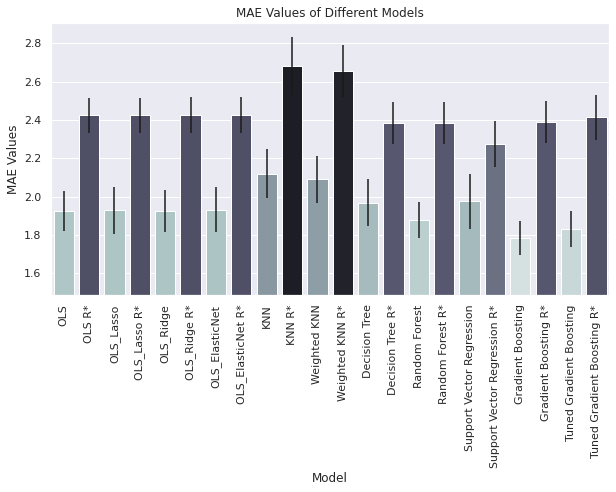

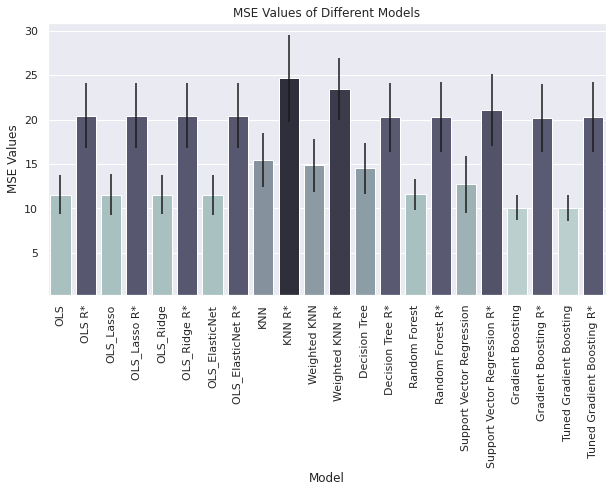

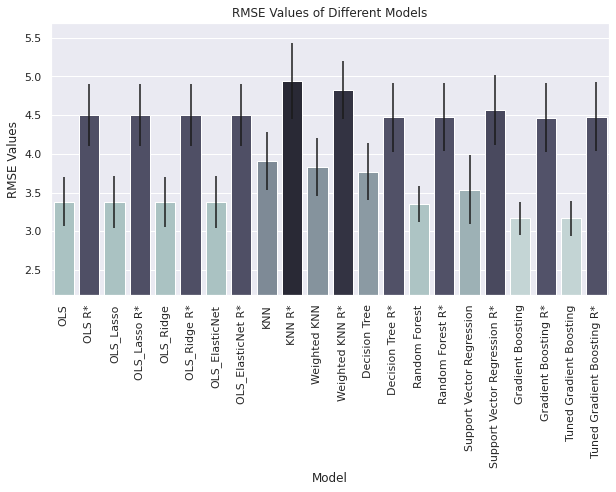

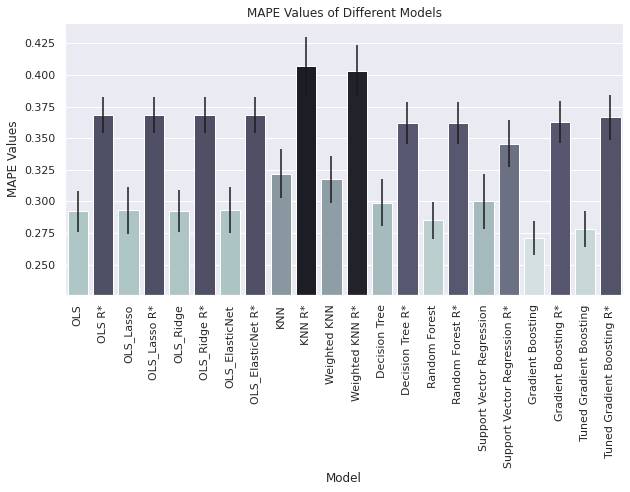

In [ ]:
for i in range(1,12,2):
  
  col = performance_cv.columns[i]
  sd_col = performance_cv.columns[i+1]

  vals = performance_cv[col]
  vals_sd = performance_cv[sd_col]
  mdls = performance_cv['Model']

  norm = plt.Normalize(vals.values.min()-vals_sd.values.max(), vals.values.max()+vals_sd.values.max())

  if i<5:
    colors = plt.cm.bone(norm(vals))
  else:
    colors = plt.cm.bone_r(norm(vals))

  plt.figure(figsize=(10,5))

  ax = sns.barplot(y=vals, x=mdls, yerr=vals_sd, palette=colors)
  plt.ylabel('{} Values'.format(col))
  plt.title('{} Values of Different Models'.format(col))
  plt.xticks(rotation=90)
  plt.ylim(round(vals.values.min()-2*vals_sd.values.max(),3),round(vals.values.max()+2*vals_sd.values.mean(),3))

  plt.show()

Ideally, based on the crime an individual is accused of committing and a few other factors - like history of offenses, the sentence length should be predetermined. Why do some people get sentenced for significantly longer than other people for the same crimes? Clearly, personal bias comes into play here. Factors such as age and race play a large factor in determining one's sentence length. 

In an ideal world, a KNN model would be a hyper-accurate model - those who had the same parameters for their crime, history and other contextual data would be sentenced for the same amount of time. However, this is not the case. There is so much variation in each case that KNN ends up being the worst performing model. Variation in sentencing based on personal information seems like an incredibly unjust system - and it is.

A pattern that I noticed in each of the models predictions was that they all under-predicted longer sentences. This leads me to believe that there was recurring bias in the sentencing of these individuals. Is it something that occurs during the trial? Does it depend on the lawyers or judge involved? 

A final note on some of the extremes and outliers in the dataset. Almost all of those extreme values in sentence length were Black. Let's take a deeper look at those.

In [ ]:
extremes['Race: Black'].mean()

0.8

80% of these extreme sentences were given to Black people.

In [ ]:
B_ex = extremes[extremes['Race']=='Black']
W_ex = extremes[extremes['Race']=='White']

In [ ]:
print(B_ex['Sentence Length'].mean())
print(W_ex['Sentence Length'].mean())

271.875
173.75


The average extreme sentence for a Black person is 272 years, while the average extreme sentence for a White person is 174 years.

While these are notes about outliers and can't necessarily be rigorously proven to represent the Illinois Department of Corrections, it is interesting to look at.

#Future Work

I think that there is a lot of potential to expand on the work conducted in this project. A similar model could be used on other correctional datasets to predict sentencing lengths, or to assess the biases within the correctional system.

This data had a few shortcomings - since I only had access to the parole population, I couldn't assess the relationships between features and sentence length for current inmates. These were all people who had been processed in September of 2020, and so I couldn't look at or assess trend data over time, to see whether sentencing has become more or less biased as time has gone on. 

I also would have liked to have data on who was represented by a public defender and financial data on each inmate. It could have been really interesting to look at how having a public defender or being from a certain socio-economic class affects one's sentence length.

The last addition I would have liked to work on would be to specifically look at non-violent crimes and show the racial differences in sentencing length for certain crimes. There is a history of people of color being arrested at incredibly high rates for non-violent drug possession and it would be valuable to assess that kind of data and look at the variation in sentence length.